In [45]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


Read all files

In [46]:
# Cell 2: Read Caliper files and create Thicket object
import os
import re
from glob import glob
import thicket as th
import pandas as pd

# Get list of all Caliper files
cali_files = glob("/scratch/user/ishaan2947/Project/caliper_files/*/*.cali")

# Create Thicket object from Caliper files
tk = th.Thicket.from_caliperreader(cali_files)


(2/2) Creating Thicket: 100%|██████████| 279/279 [00:10<00:00, 26.39it/s]


View Calltree

In [47]:
# Cell 3: Inspect the Thicket object's metadata and dataframe
print("Available metadata columns:")
print(tk.metadata.columns.tolist())

print("\nSample metadata:")
print(tk.metadata.head())

print("\nAvailable performance data columns:")
print(tk.dataframe.columns.tolist())

print("\nSample performance data:")
print(tk.dataframe.head())


Available metadata columns:
['cali.caliper.version', 'mpi.world.size', 'spot.metrics', 'spot.timeseries.metrics', 'spot.format.version', 'spot.options', 'spot.channels', 'cali.channel', 'spot:node.order', 'spot:output', 'spot:profile.mpi', 'spot:region.count', 'spot:time.exclusive', 'spot:time.variance', 'launchdate', 'libraries', 'cmdline', 'cluster', 'algorithm', 'programming_model', 'data_type', 'size_of_data_type', 'input_size', 'input_type', 'num_procs', 'scalability', 'group_num', 'implementation_source']

Sample metadata:
         cali.caliper.version  mpi.world.size  \
profile                                         
1791343                2.11.0              32   
5085741                2.11.0              64   
11115611               2.11.0            1024   
13586793               2.11.0               8   
43645987               2.11.0             256   

                                               spot.metrics  \
profile                                                   

Group Performance data by `matrix_size` in the Thicket metadata table.

In [48]:
# Cell 4: Use existing metadata from Thicket
# Check if 'mpi.world.size' is available in tk.metadata
if 'mpi.world.size' in tk.metadata.columns:
    tk.metadata['num_procs'] = tk.metadata['mpi.world.size'].astype(int)
else:
    print("'mpi.world.size' not found in metadata.")


if 'input_size' in tk.metadata.columns:
    tk.metadata['array_size'] = tk.metadata['input_size'].astype(int)
else:
    print("'input_size' not found in metadata.")


if 'input_type' in tk.metadata.columns:
    tk.metadata['input_type'] = tk.metadata['input_type']
else:
    print("'input_type' not found in metadata.")


tk.metadata_column_to_perfdata('num_procs')
tk.metadata_column_to_perfdata('array_size')
tk.metadata_column_to_perfdata('input_type')

# Display updated metadata
print("\nUpdated tk.metadata:")
print(tk.metadata.head())



Updated tk.metadata:
         cali.caliper.version  mpi.world.size  \
profile                                         
1791343                2.11.0              32   
5085741                2.11.0              64   
11115611               2.11.0            1024   
13586793               2.11.0               8   
43645987               2.11.0             256   

                                               spot.metrics  \
profile                                                       
1791343   min#inclusive#sum#time.duration,max#inclusive#...   
5085741   min#inclusive#sum#time.duration,max#inclusive#...   
11115611  min#inclusive#sum#time.duration,max#inclusive#...   
13586793  min#inclusive#sum#time.duration,max#inclusive#...   
43645987  min#inclusive#sum#time.duration,max#inclusive#...   

         spot.timeseries.metrics  spot.format.version  \
profile                                                 
1791343                                             2   
5085741              

In [49]:
# Cell 5: Prepare the performance dataframe

# Reset index of tk.dataframe
tk.dataframe.reset_index(inplace=True)

# Check if 'rank' data is available
print("Performance Dataframe Columns after reset_index:")
print(tk.dataframe.columns.tolist())

if 'rank' in tk.dataframe.columns:
    print("'rank' column is present in tk.dataframe.")
else:
    print("'rank' column is NOT present in tk.dataframe.")
    # Check if 'profile' can be used as 'rank'
    print("\nSample 'profile' values:")
    print(tk.dataframe['profile'].head())
    print("\nNumber of unique 'profile' values:")
    print(tk.dataframe['profile'].nunique())
    
    
    use_profile_as_rank = True  # Set this based on your investigation
    
    if use_profile_as_rank:
        # Rename 'profile' to 'rank'
        tk.dataframe.rename(columns={'profile': 'rank'}, inplace=True)
        print("\nRenamed 'profile' column to 'rank'.")
    else:
        print("\nProceeding without 'rank' in the index.")

# Now proceed to set the index
if 'rank' in tk.dataframe.columns:
    tk.dataframe.set_index(['node', 'num_procs', 'array_size', 'input_type', 'rank'], inplace=True)
else:
    tk.dataframe.set_index(['node', 'num_procs', 'array_size', 'input_type'], inplace=True)

# Display the updated dataframe
print("\nUpdated tk.dataframe:")
print(tk.dataframe.head())


Performance Dataframe Columns after reset_index:
['node', 'profile', 'nid', 'spot.channel', 'Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank', 'Calls/rank (min)', 'Calls/rank (avg)', 'Calls/rank (max)', 'Calls/rank (total)', 'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)', 'Total time (exc)', 'name', 'num_procs', 'array_size', 'input_type']
'rank' column is NOT present in tk.dataframe.

Sample 'profile' values:
0     1791343
1     5085741
2    11115611
3    13586793
4    43645987
Name: profile, dtype: int64

Number of unique 'profile' values:
280

Renamed 'profile' column to 'rank'.

Updated tk.dataframe:
                                                                                        nid  \
node                                         num_procs array_size input_type rank             
{'name': 'MPI_Comm_dup', 'type': 'function'} 32        4194304    reverse    1791343   27.0   
                                             6

In [50]:
# Cell 6: Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
array_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]


input_types = ['sorted', 'random', 'reverse', 'nearly_sorted']


nodes_of_interest = ['main', 'MPI_Barrier', 'MPI_Send', 'MPI_Recv']  


In [51]:
# Cell 7: Set plot font size
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 14})


In [52]:
# Cell 8: Compute performance metrics

import re

# Identify the time metric
time_metric = 'Avg time/rank'  # Adjust if necessary based on your data

# Reset index to access 'node' as a column
tk.dataframe.reset_index(inplace=True)

# Ensure 'num_procs' and 'array_size' are integers
tk.dataframe['num_procs'] = tk.dataframe['num_procs'].astype(int)
tk.dataframe['array_size'] = tk.dataframe['array_size'].astype(int)

# Extract 'name' field from 'node' column
def extract_node_name(node):
    if hasattr(node, 'attributes') and 'name' in node.attributes:
        return node.attributes['name']
    else:
        # Try to parse as string using regex
        node_str = str(node)
        match = re.search(r"'name': '([^']+)'", node_str)
        if match:
            return match.group(1)
        else:
            return node_str

tk.dataframe['node_name'] = tk.dataframe['node'].apply(extract_node_name)

# Print unique node names
print("Unique node names:")
print(tk.dataframe['node_name'].unique())


nodes_of_interest = ['main', 'comm', 'comm_large', 'comp', 'comp_large', 'comp_small', 'mpi_bitonic_sort',
                     'MPI_Send', 'MPI_Recv', 'MPI_Barrier', 'MPI_Scatter', 'MPI_Gather', 'data_init_runtime']

# Filter data for nodes of interest
filtered_df = tk.dataframe[tk.dataframe['node_name'].isin(nodes_of_interest)]

# Check if filtered_df is empty
print("\nShape of filtered_df:", filtered_df.shape)
if filtered_df.empty:
    print("No data found for the specified nodes of interest.")
else:
    # Group data and compute metrics using agg
    grouped = filtered_df.groupby(['node_name', 'num_procs', 'array_size', 'input_type'])

    # Use agg to compute the metrics
    metrics_df = grouped[time_metric].agg(['min', 'max', 'mean', 'sum', 'var']).reset_index()

    # Rename the columns for clarity
    metrics_df.rename(columns={
        'node_name': 'node',
        'min': 'Min time/rank',
        'max': 'Max time/rank',
        'mean': 'Avg time/rank',
        'sum': 'Total time',
        'var': 'Variance time/rank'
    }, inplace=True)

    # Ensure 'num_procs' and 'array_size' are integers
    metrics_df['num_procs'] = metrics_df['num_procs'].astype(int)
    metrics_df['array_size'] = metrics_df['array_size'].astype(int)

    # Display computed metrics
    print("\nColumns in metrics_df after reset_index:")
    print(metrics_df.columns.tolist())
    print("\nSample of metrics_df:")
    print(metrics_df.head())

    # Check unique values in 'num_procs' and 'array_size'
    print("\nUnique 'num_procs' in metrics_df:")
    print(sorted(metrics_df['num_procs'].unique()))

    print("\nUnique 'array_size' in metrics_df:")
    print(sorted(metrics_df['array_size'].unique()))


Unique node names:
['MPI_Comm_dup' 'MPI_Finalize' 'MPI_Finalized' 'MPI_Initialized' 'main'
 'MPI_Barrier' 'MPI_Comm_free' 'MPI_Get_count' 'MPI_Probe' 'MPI_Recv'
 'MPI_Send' 'comm' 'comm_large' 'MPI_Gather' 'MPI_Scatter' 'comp'
 'comp_large' 'data_init_runtime' 'mpi_bitonic_sort' 'MPI_Sendrecv'
 'comp_small']

Shape of filtered_df: (4200, 22)

Columns in metrics_df after reset_index:
['node', 'num_procs', 'array_size', 'input_type', 'Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']

Sample of metrics_df:
          node  num_procs  array_size     input_type  Min time/rank  \
0  MPI_Barrier          2       65536  nearly_sorted       0.000655   
1  MPI_Barrier          2       65536         random       0.000196   
2  MPI_Barrier          2       65536        reverse       0.000200   
3  MPI_Barrier          2       65536         sorted       0.000209   
4  MPI_Barrier          2      262144  nearly_sorted       0.000387   

   Max time/rank  Avg time/

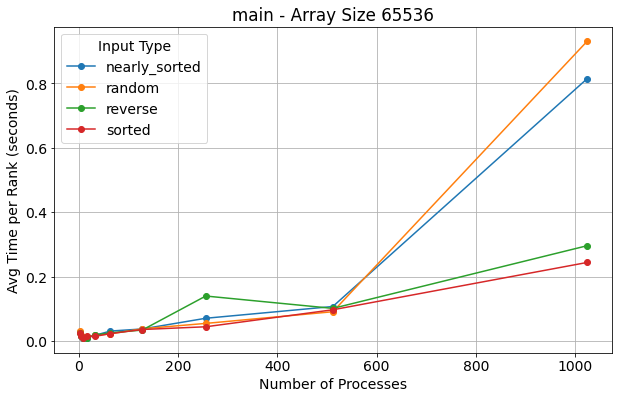

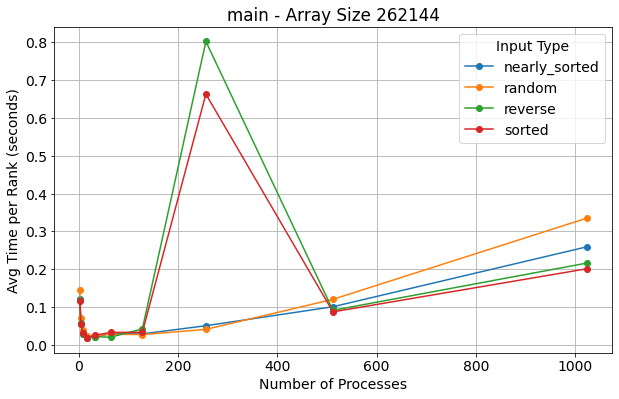

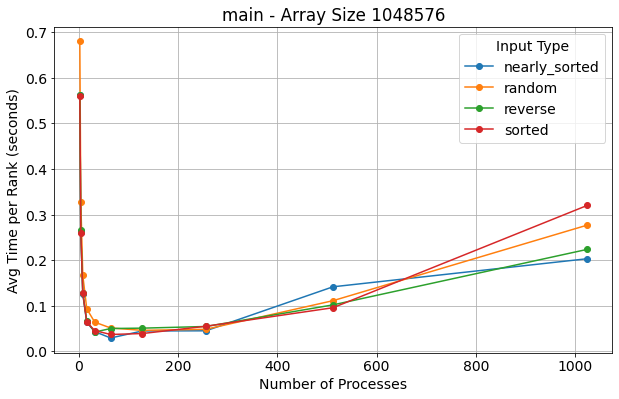

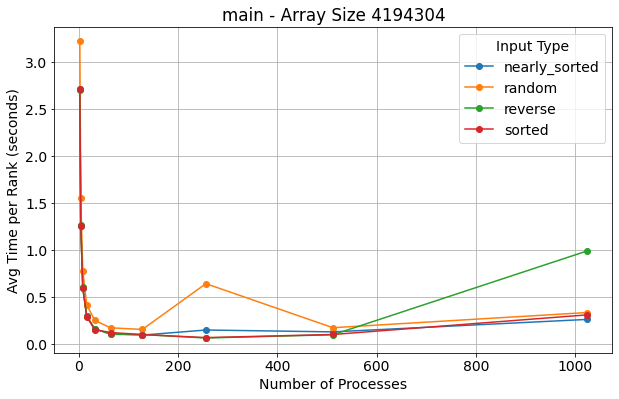

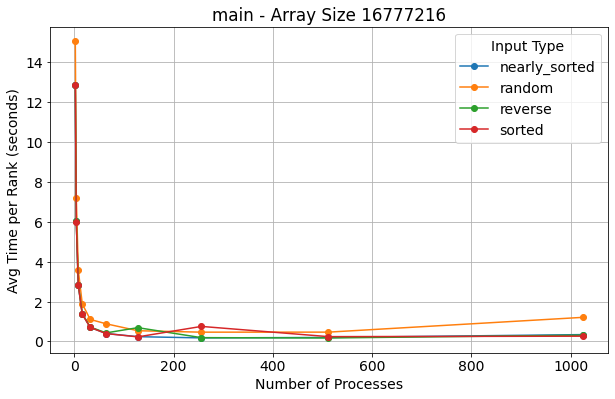

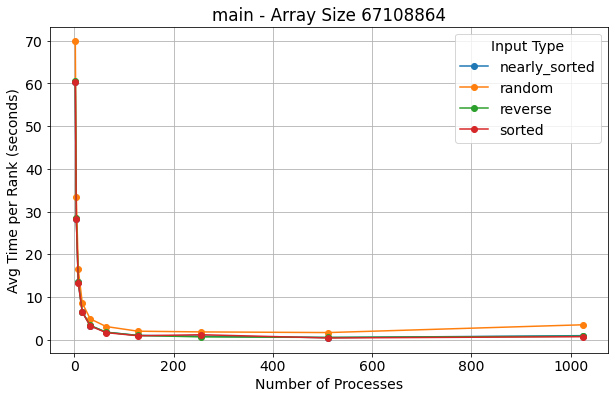

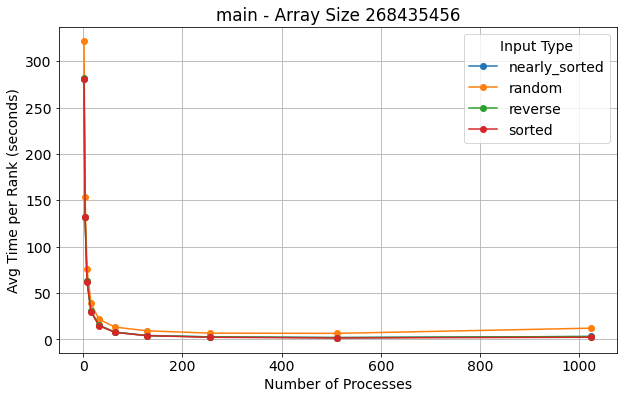

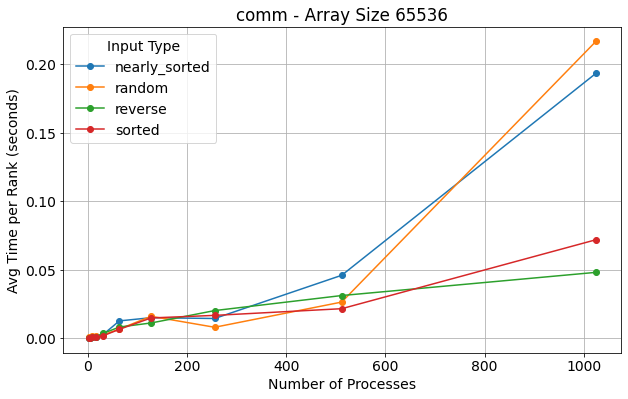

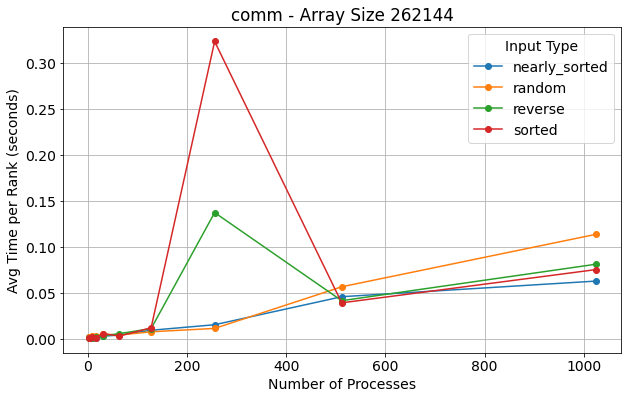

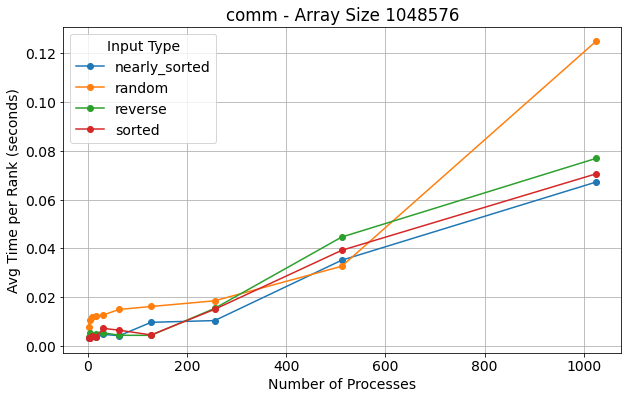

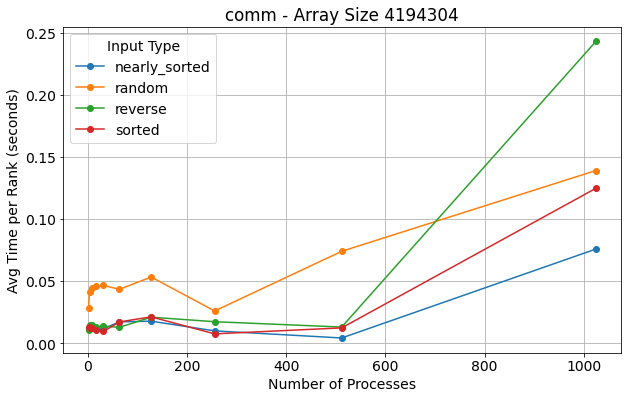

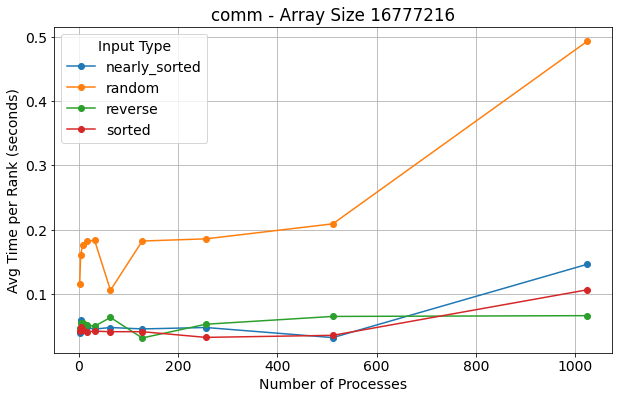

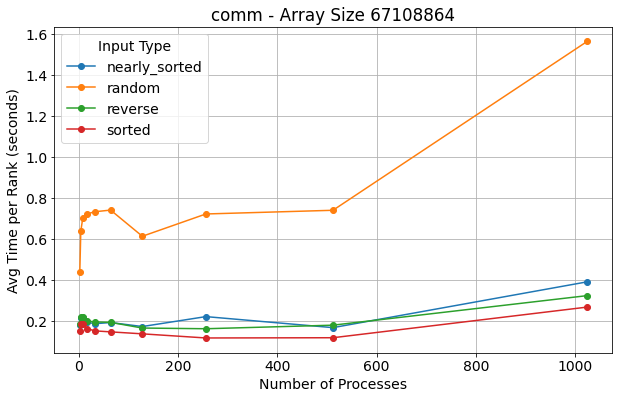

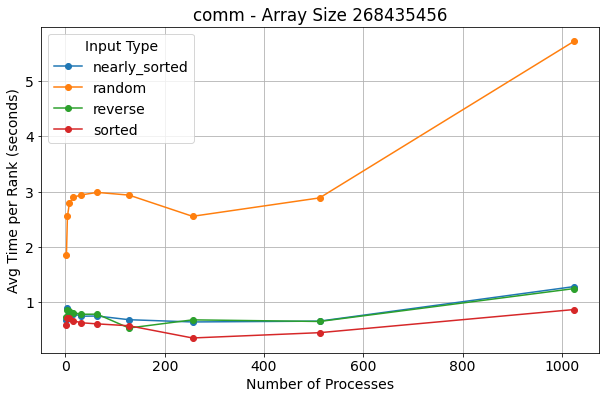

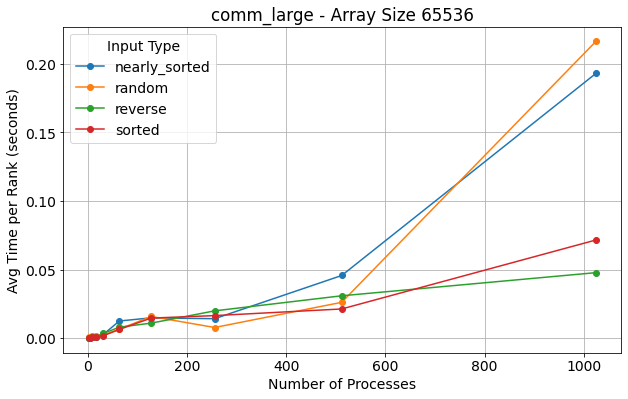

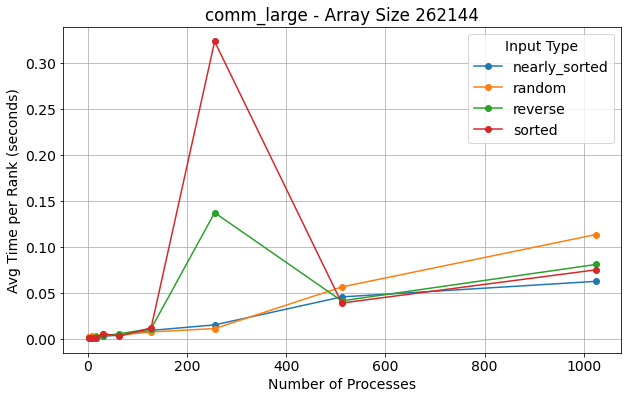

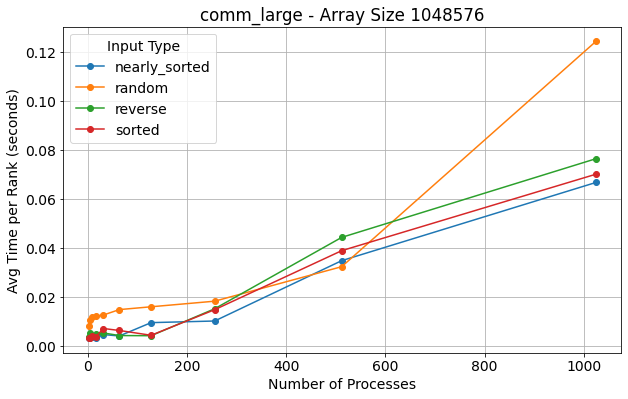

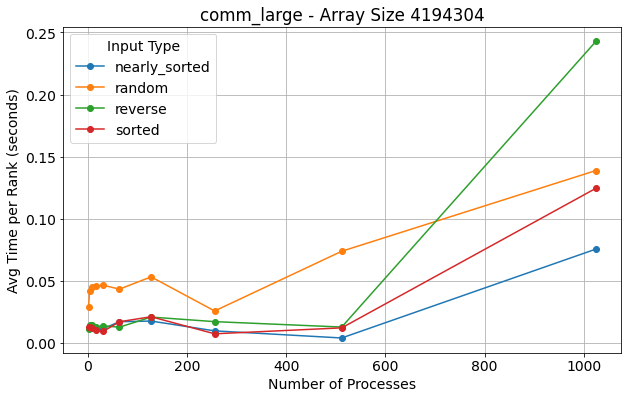

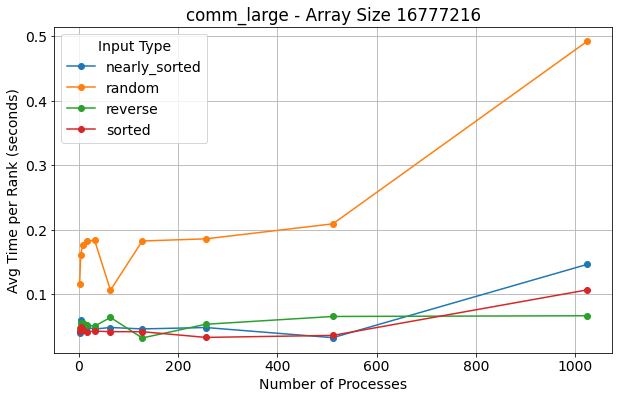

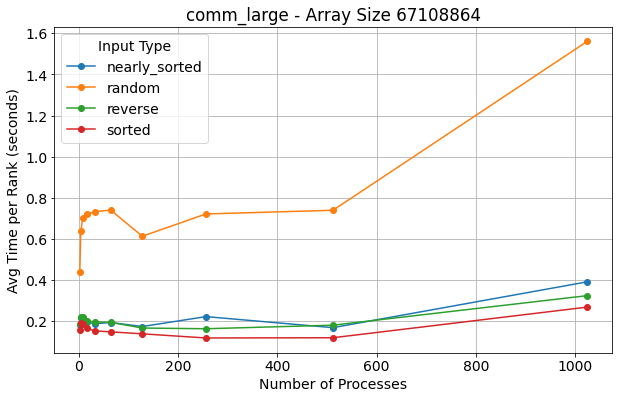

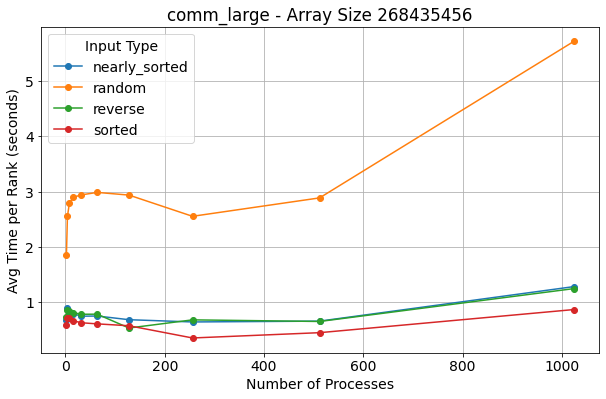

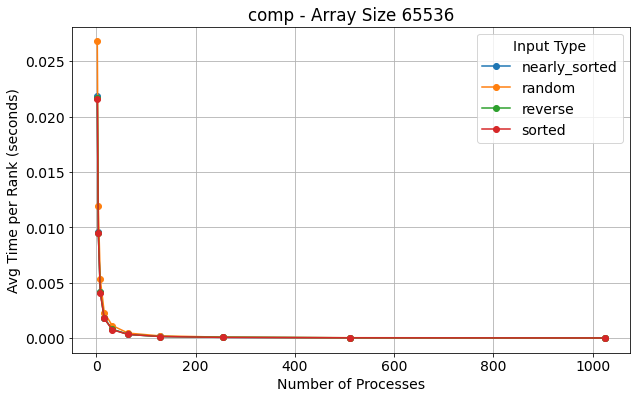

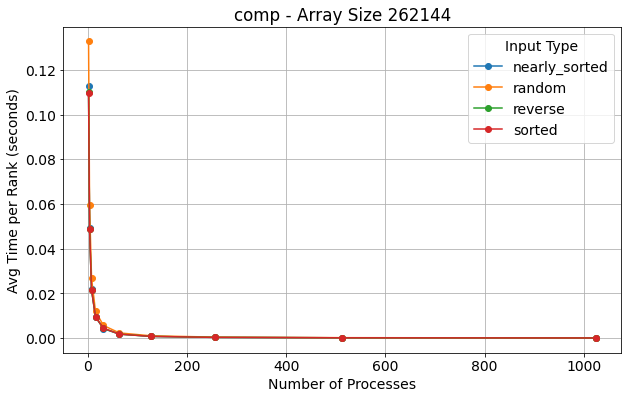

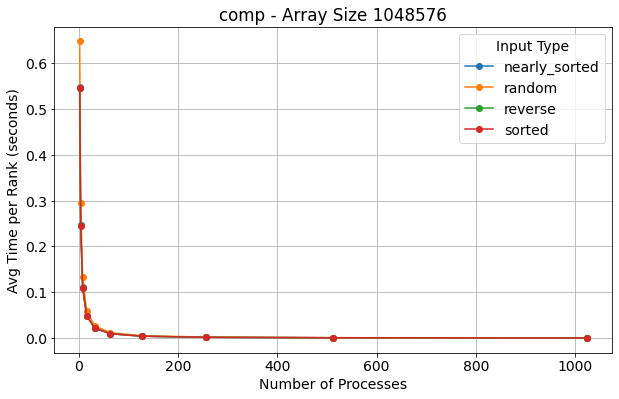

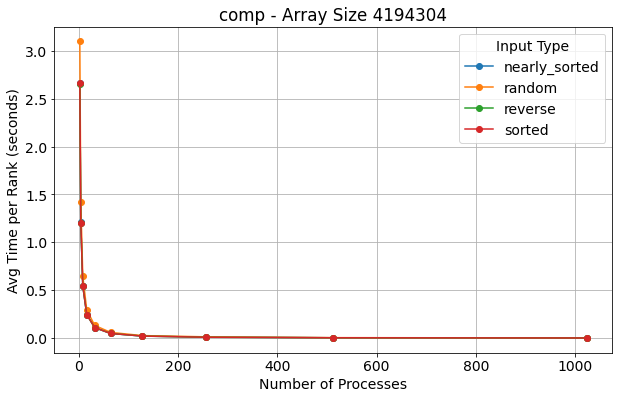

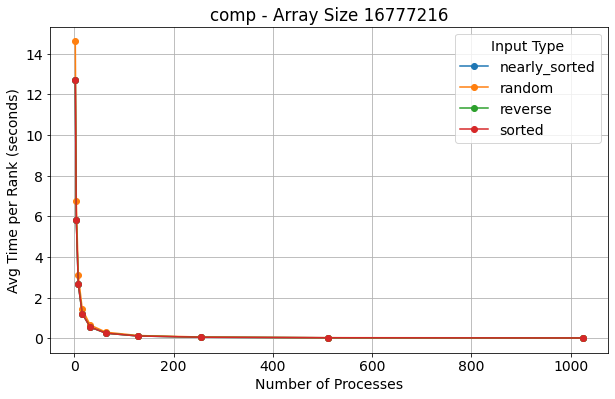

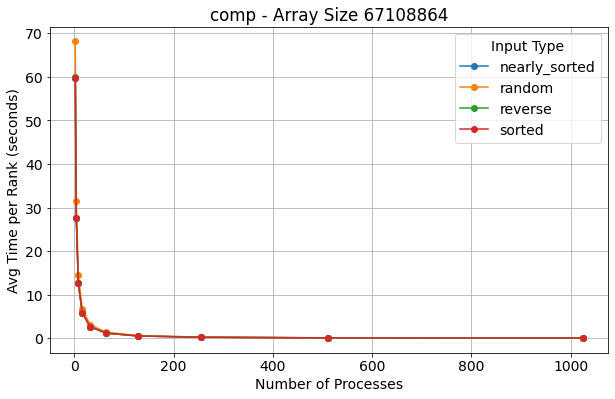

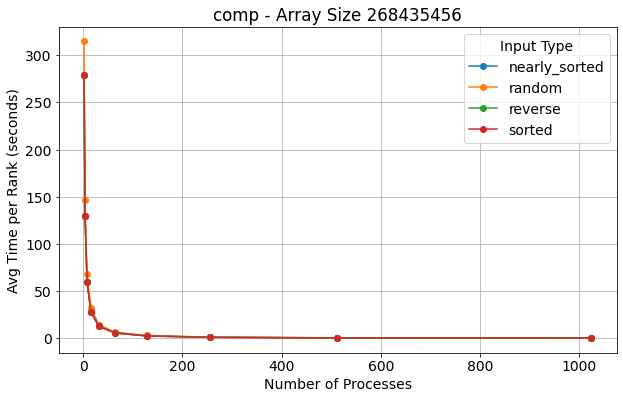

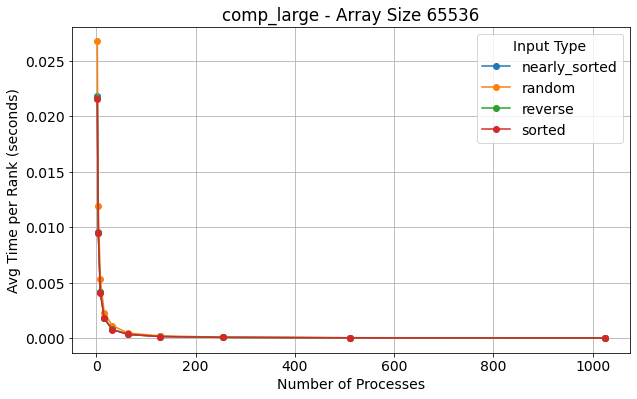

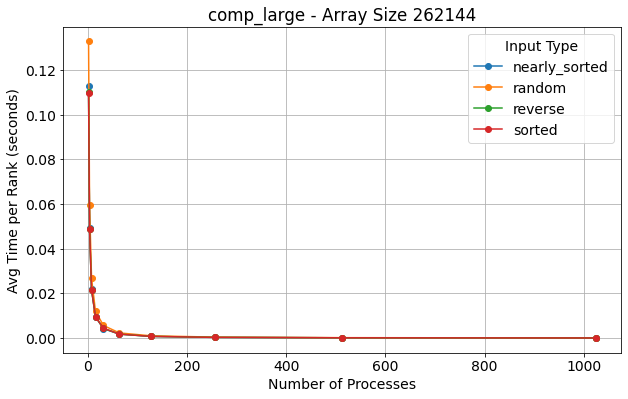

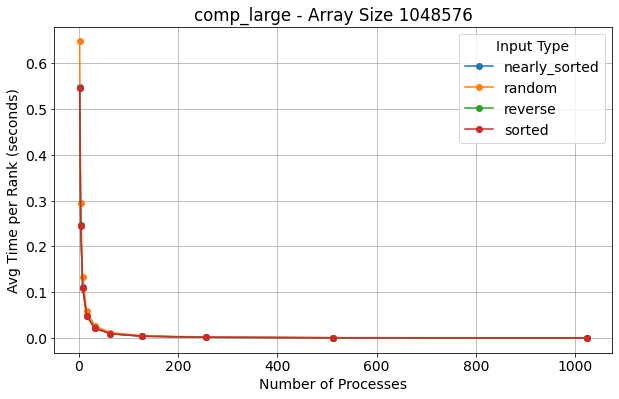

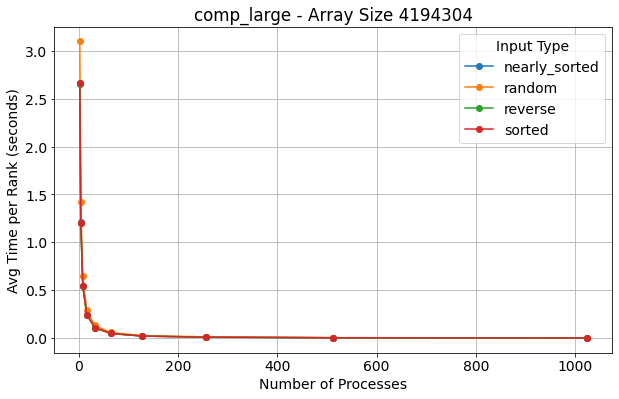

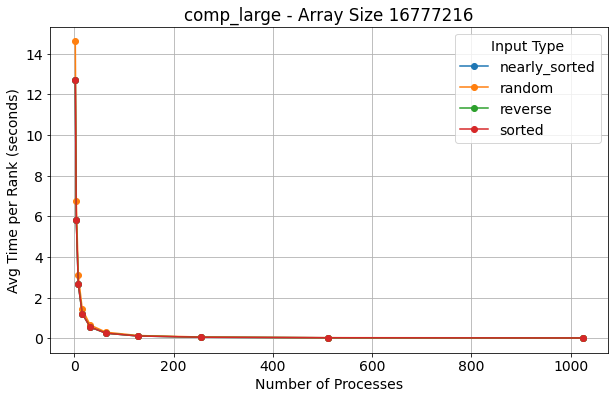

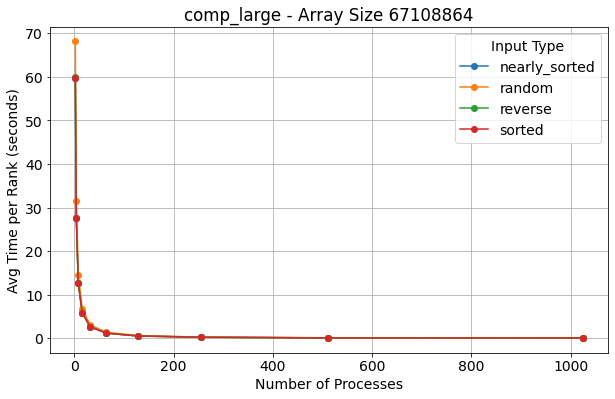

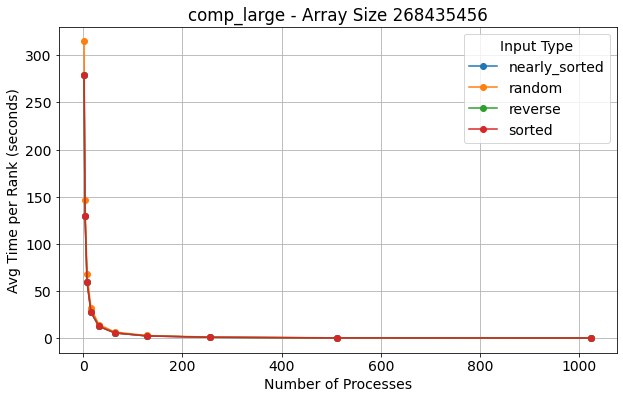

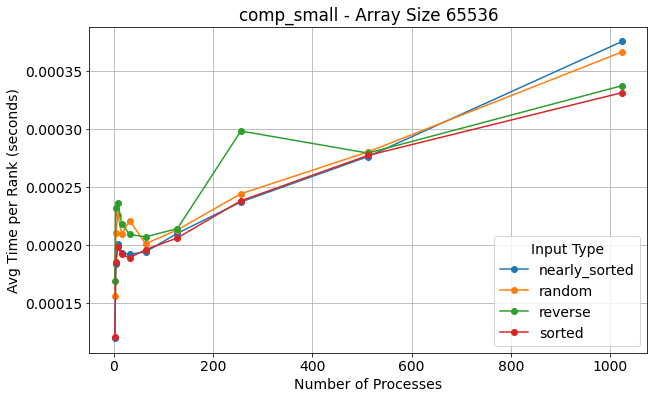

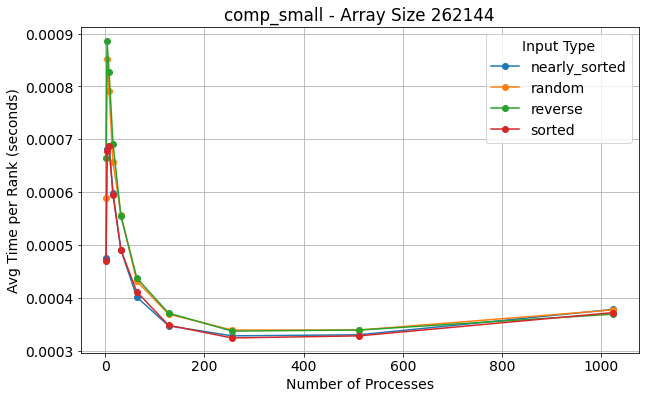

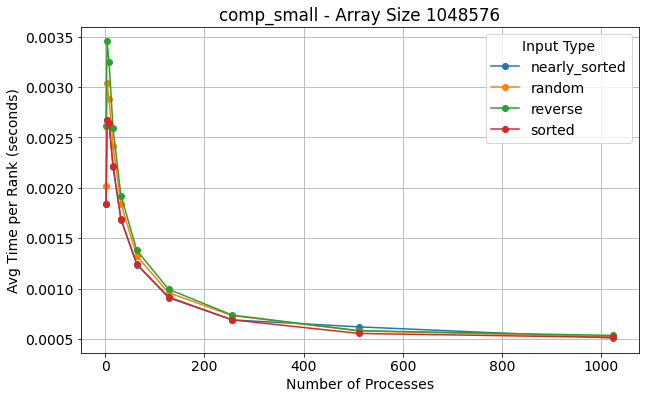

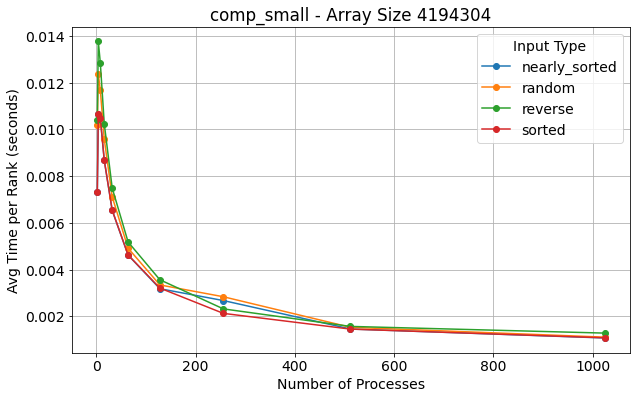

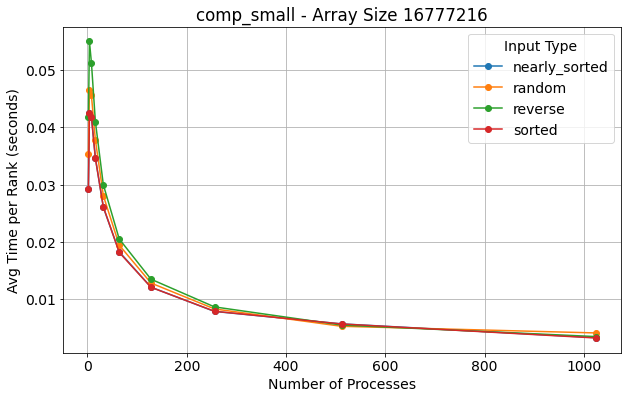

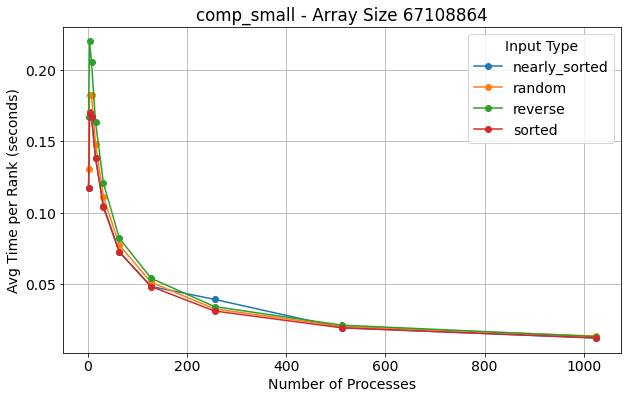

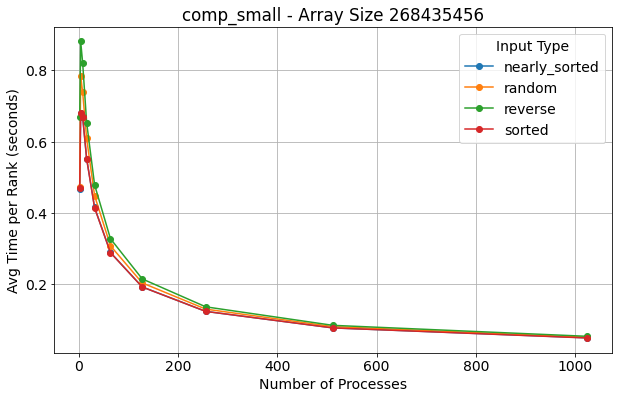

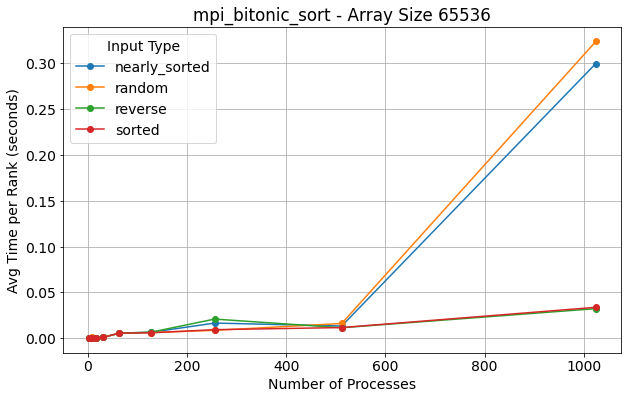

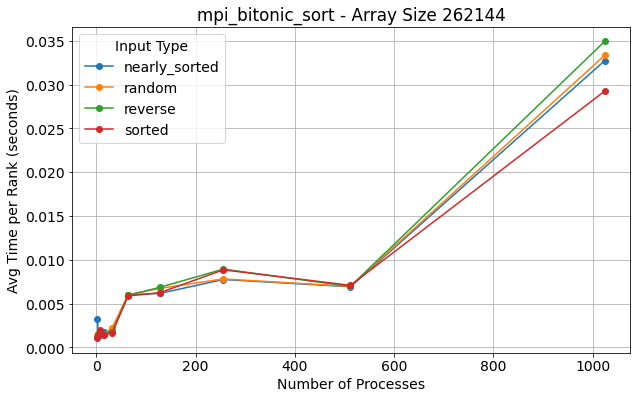

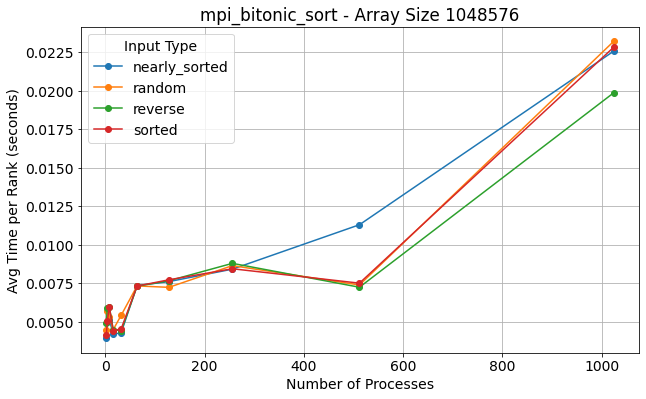

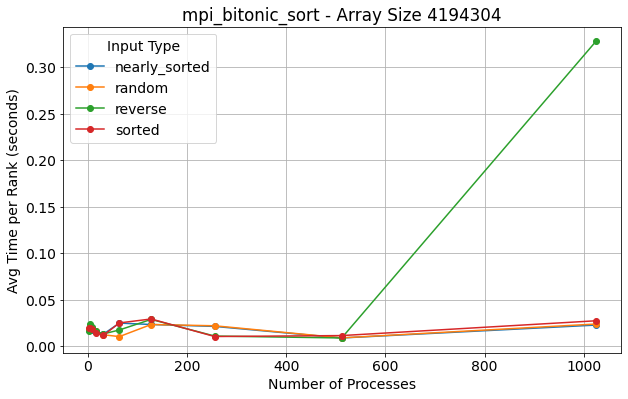

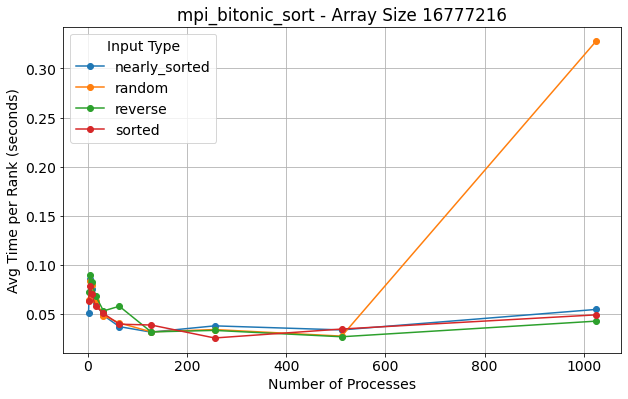

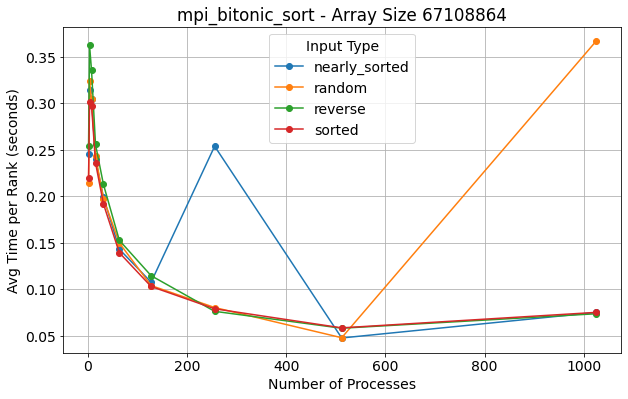

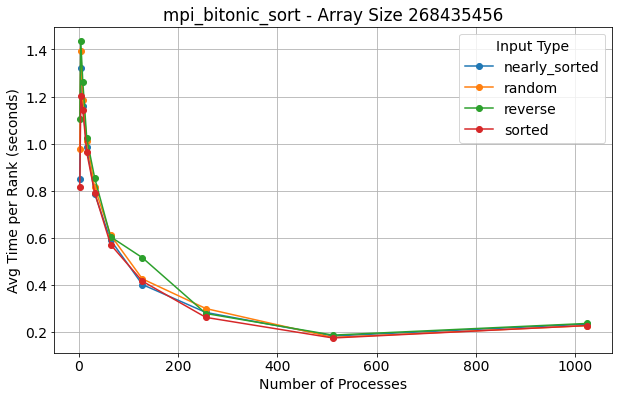

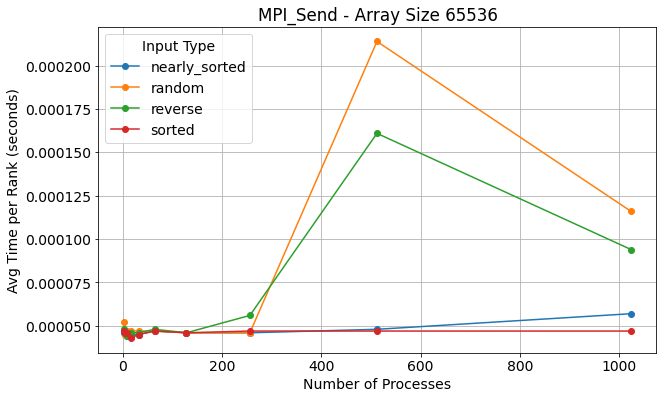

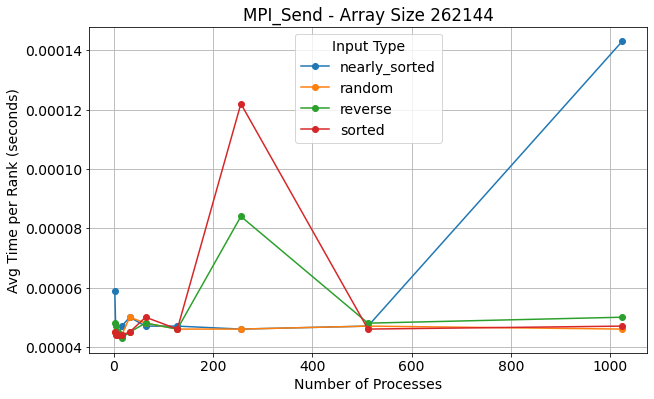

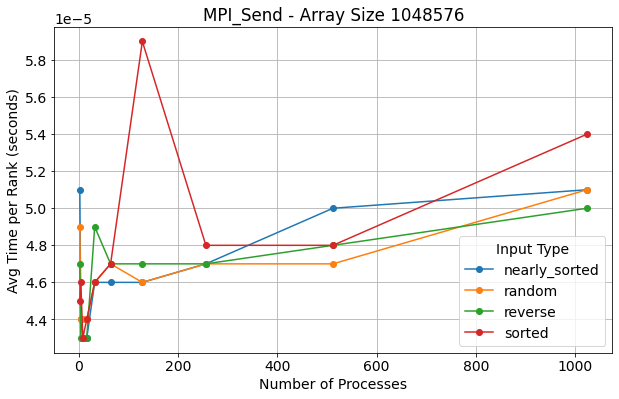

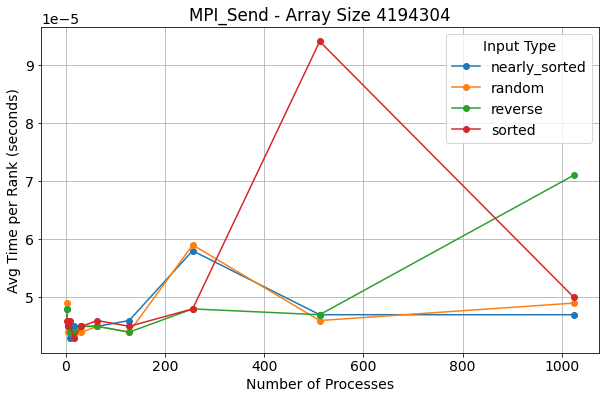

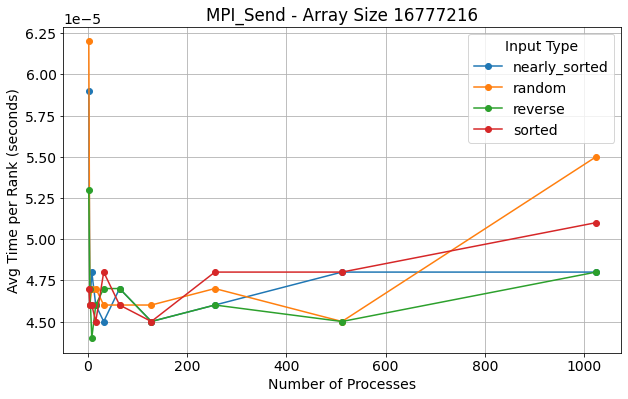

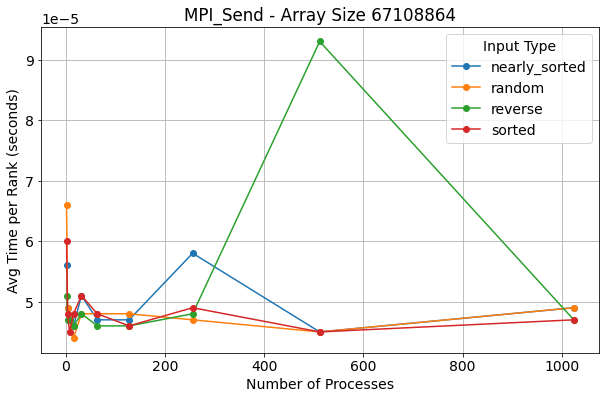

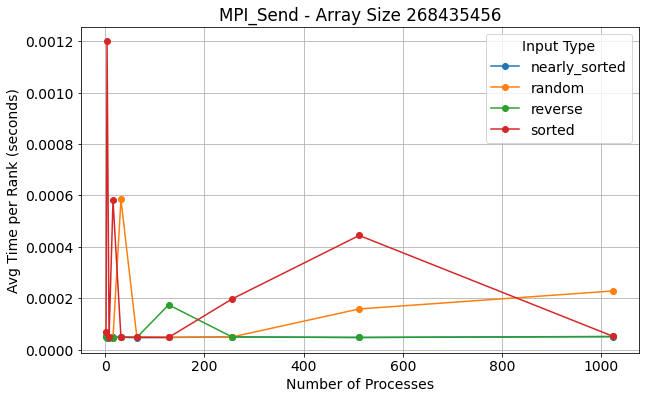

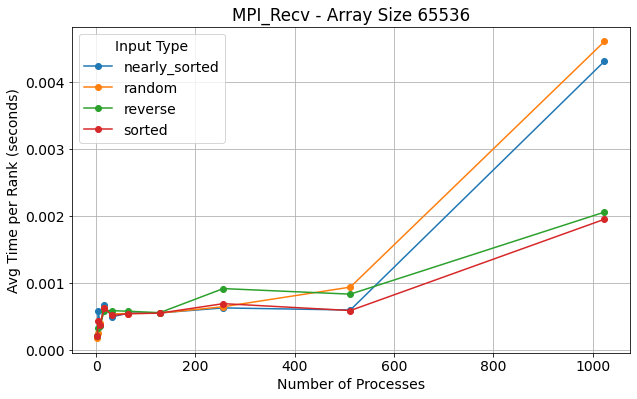

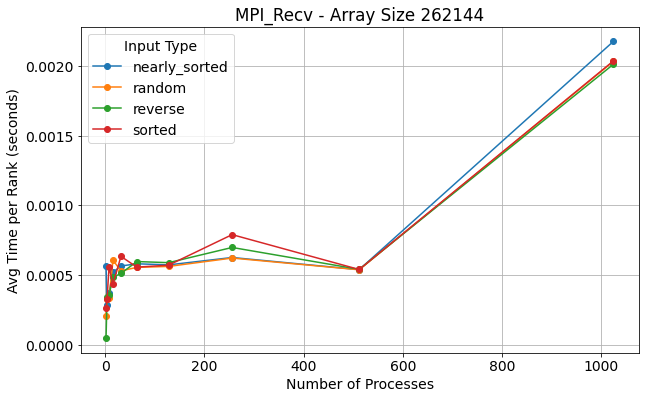

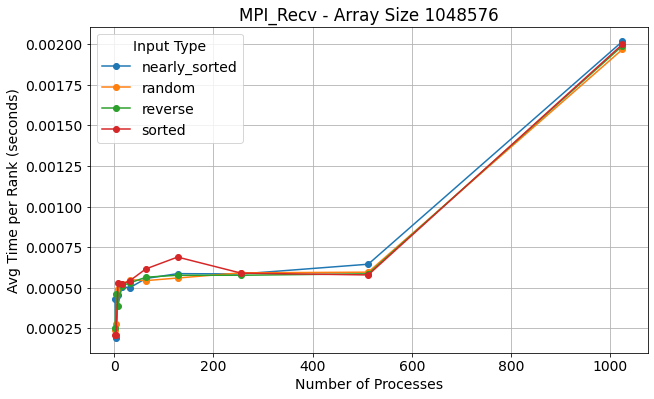

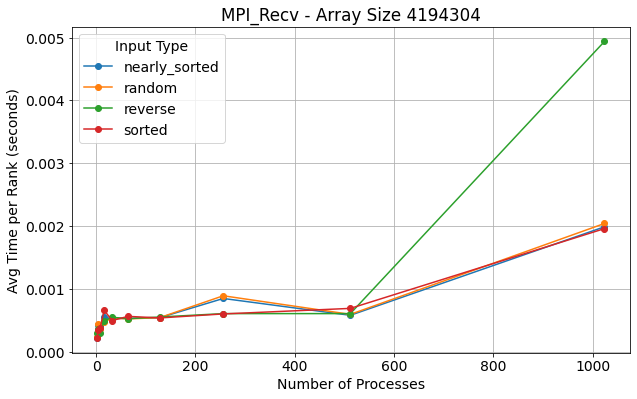

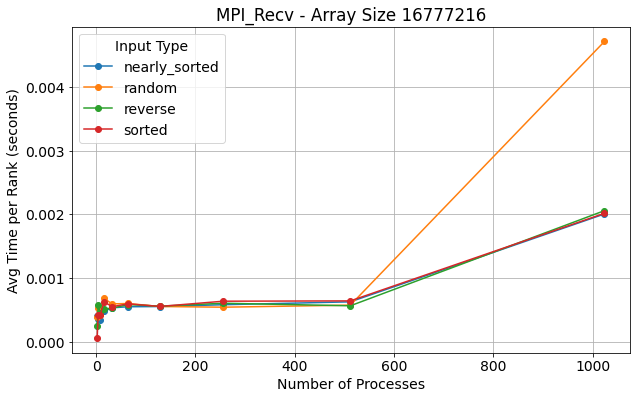

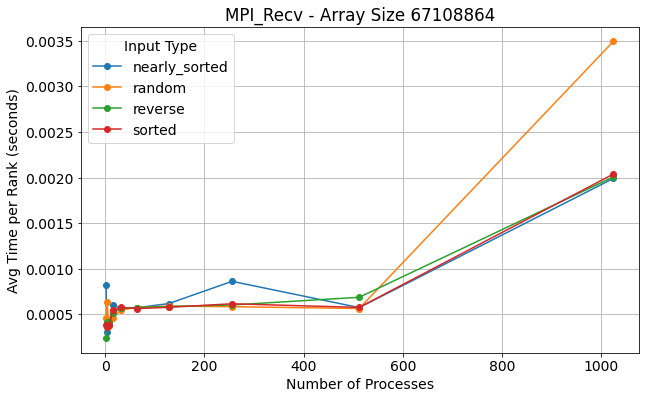

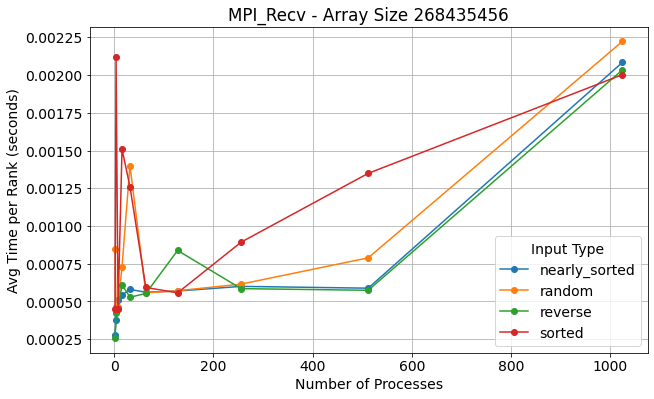

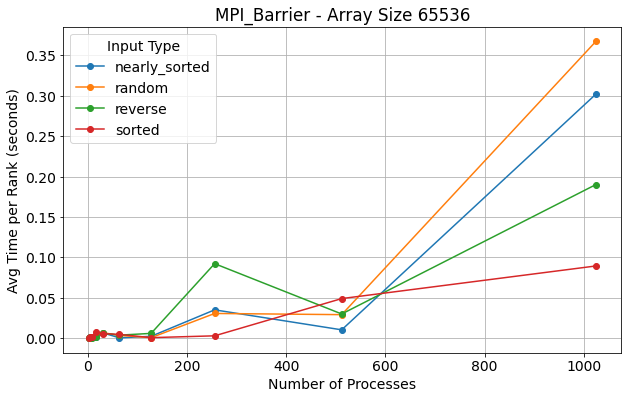

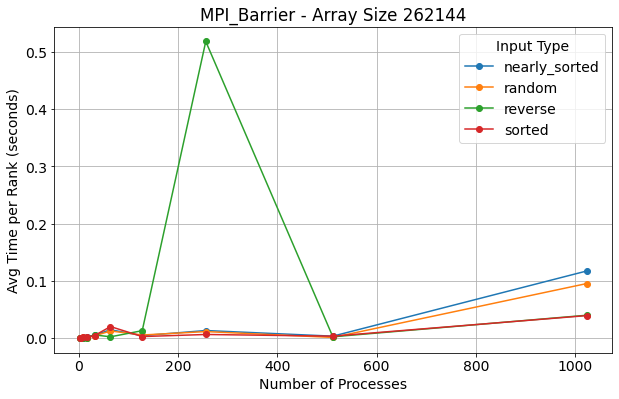

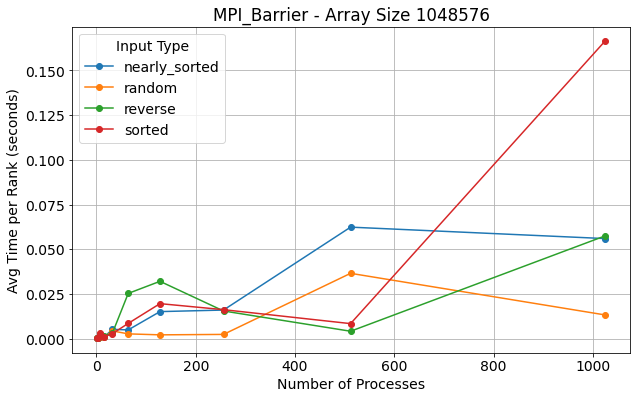

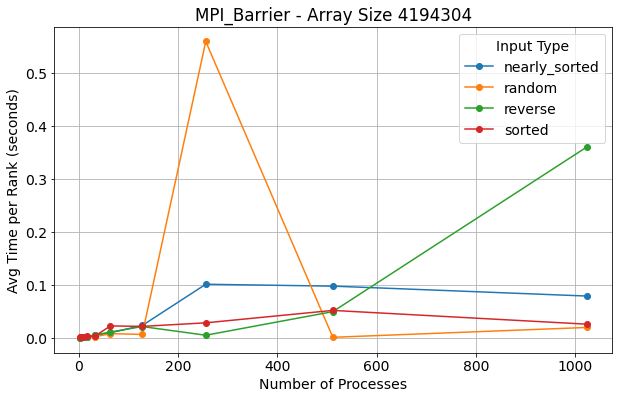

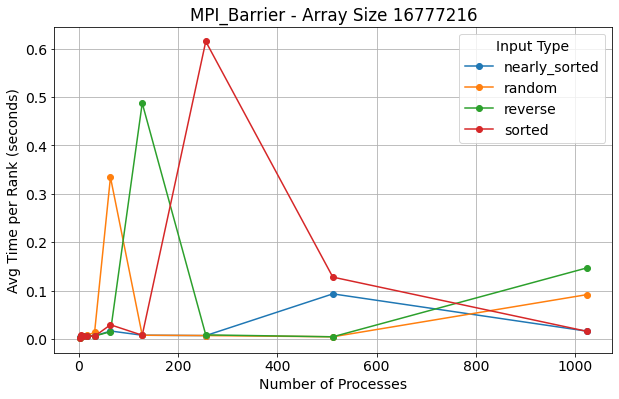

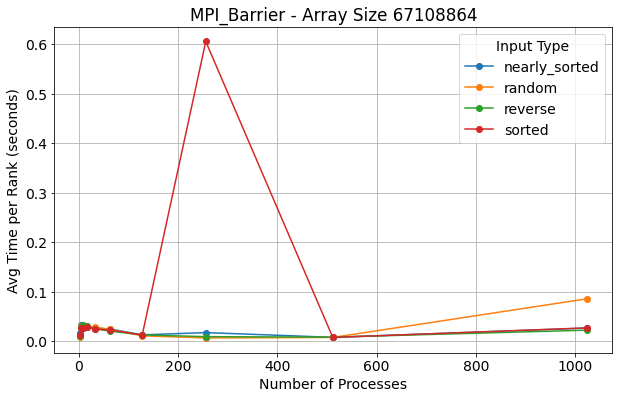

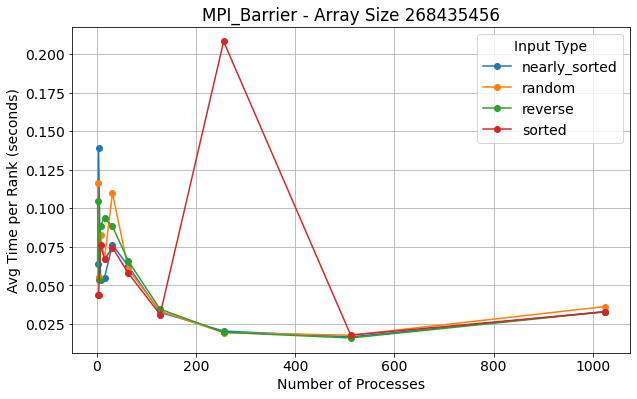

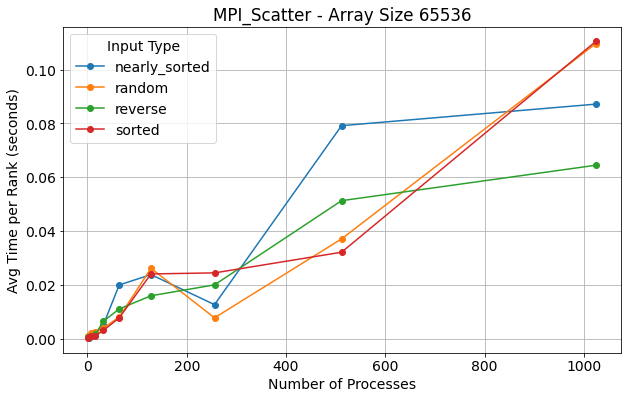

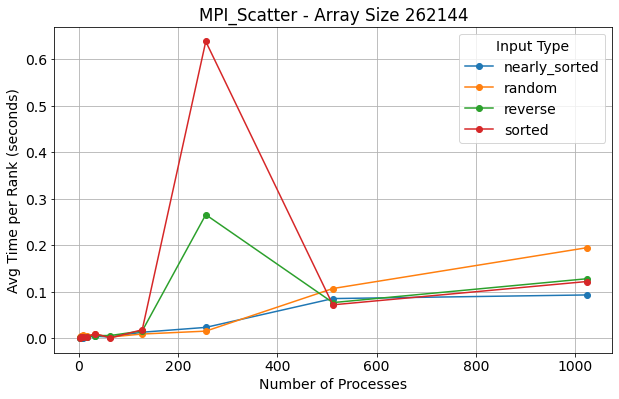

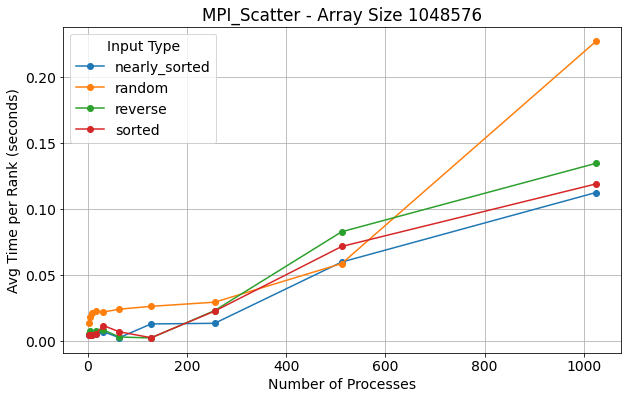

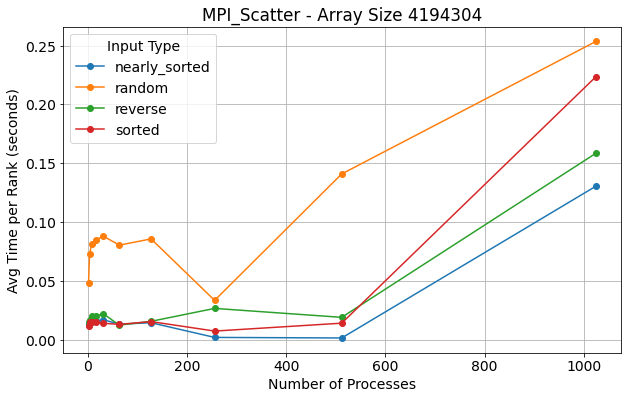

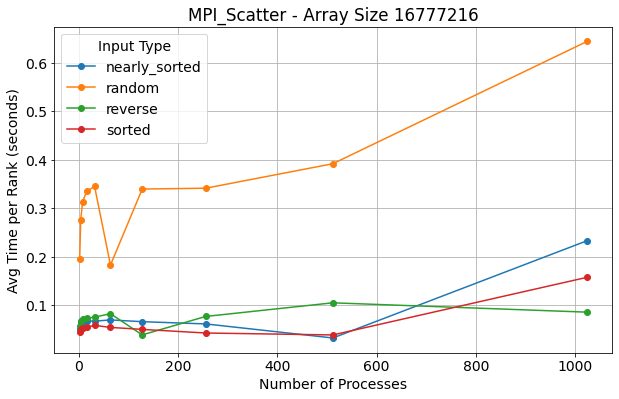

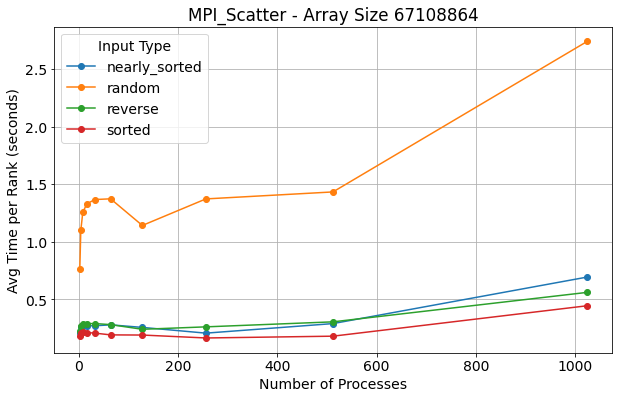

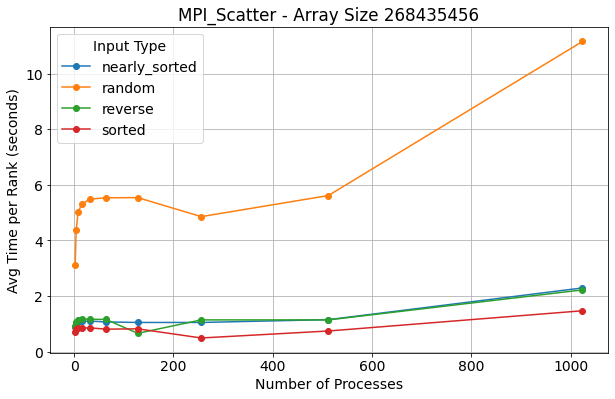

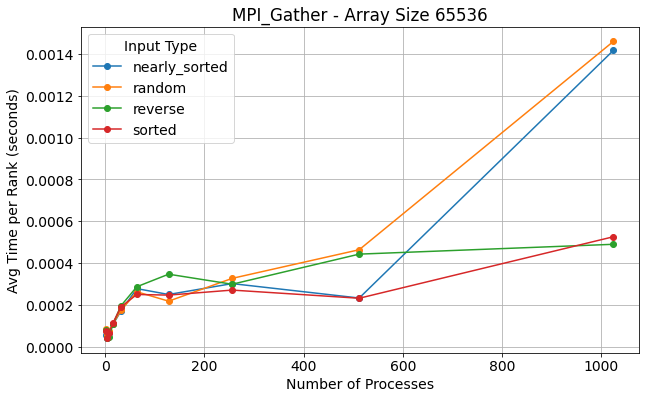

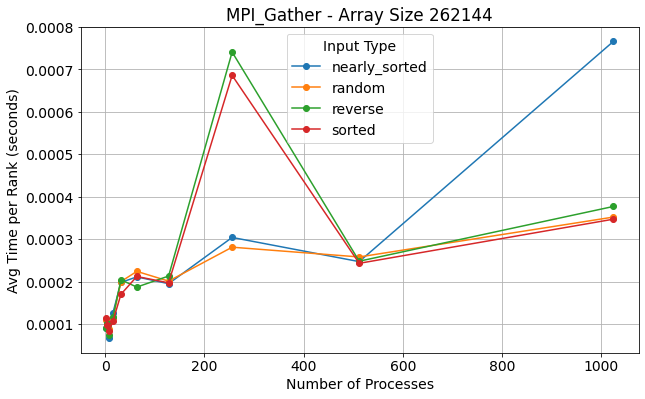

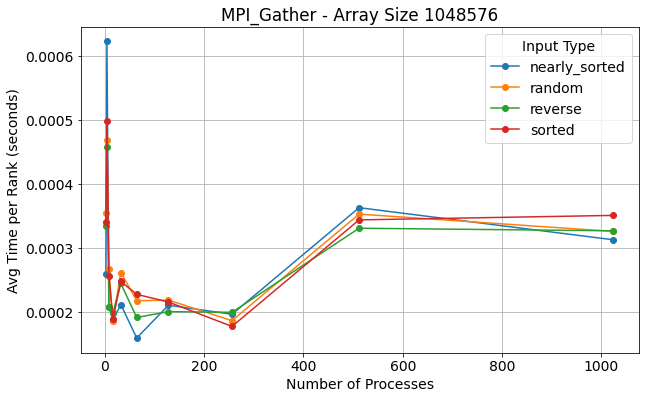

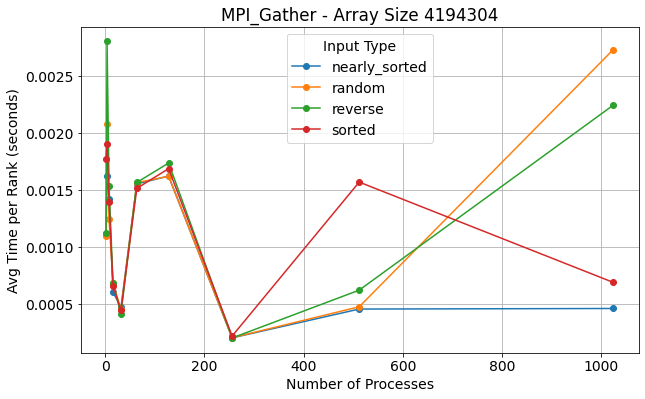

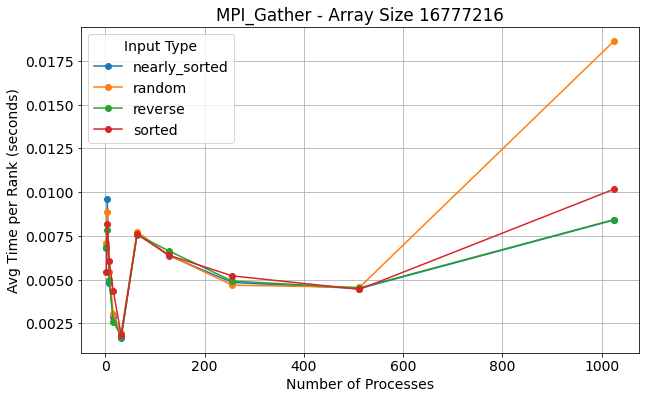

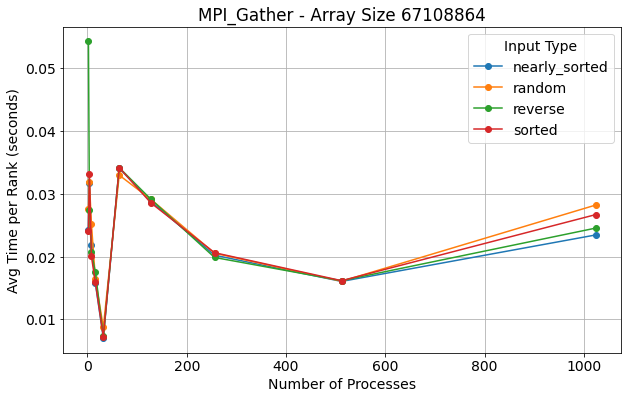

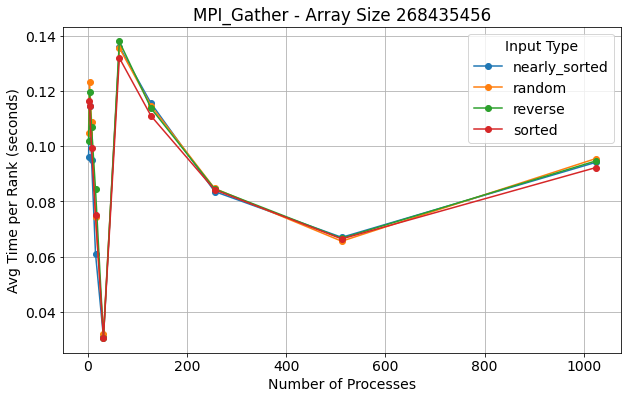

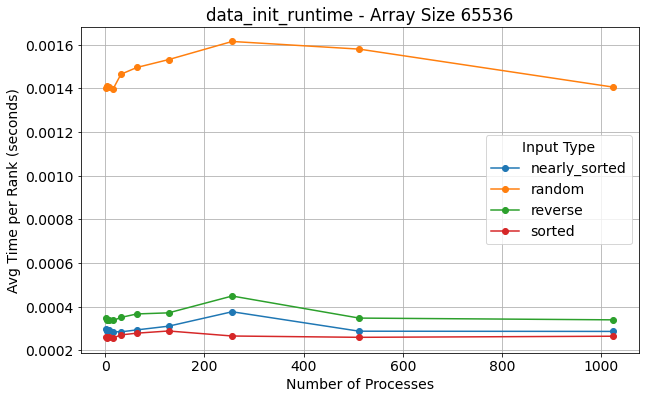

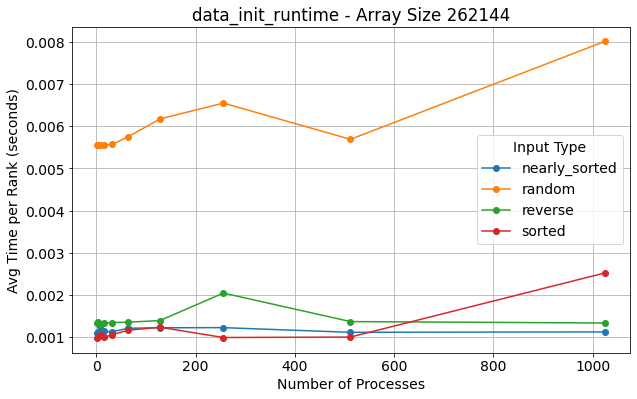

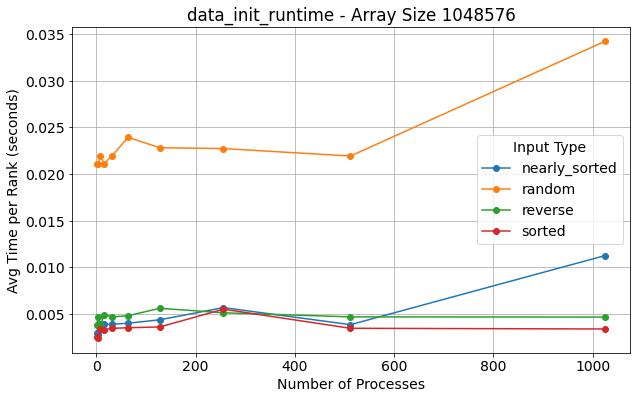

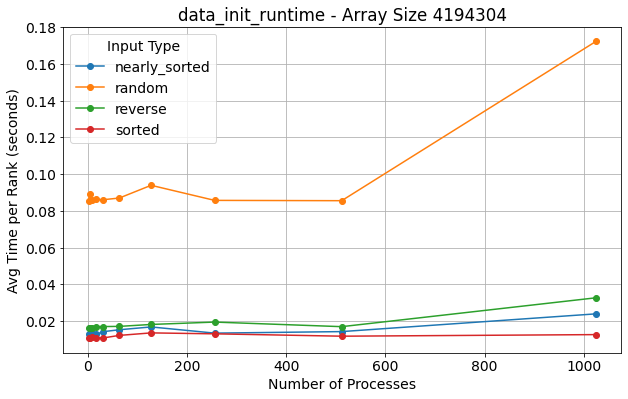

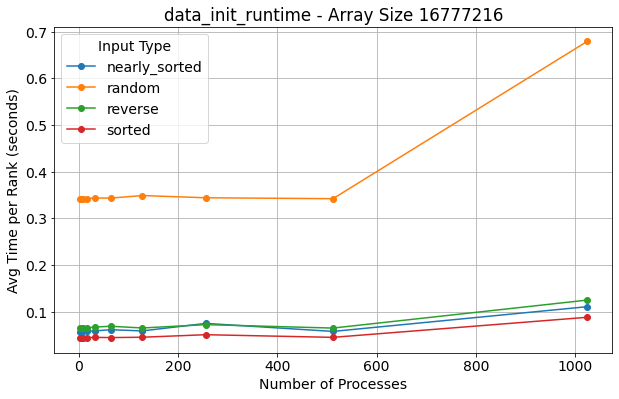

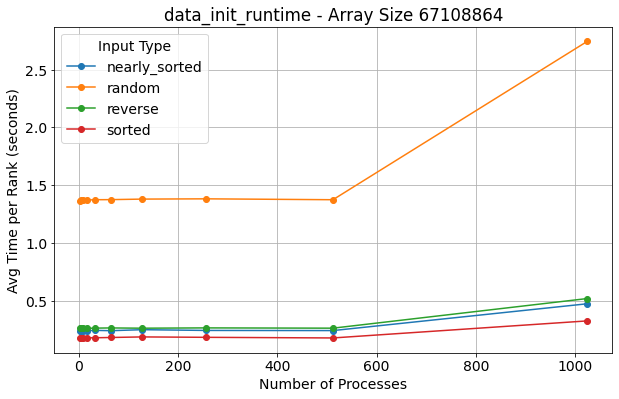

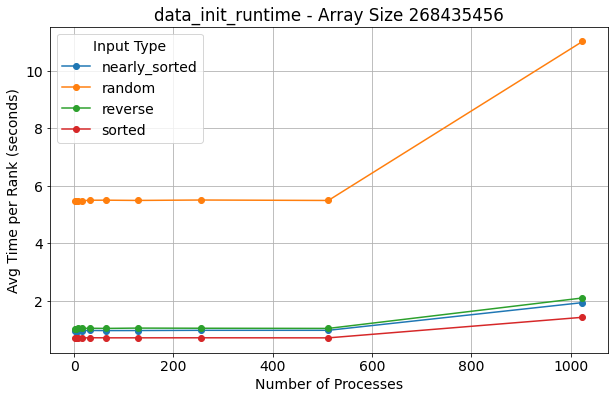

In [53]:
# Cell 9: Generate strong scaling plots for each array_size with lines for input_type
for node in nodes_of_interest:
    for array_size in array_sizes:
        data = metrics_df[(metrics_df['node'] == node) & (metrics_df['array_size'] == array_size)]
        if data.empty:
            continue
        pivot_table = data.pivot(index='num_procs', columns='input_type', values='Avg time/rank')
        pivot_table.plot(title=f"{node} - Array Size {array_size}", marker='o', figsize=(10, 6))
        plt.xlabel('Number of Processes')
        plt.ylabel('Avg Time per Rank (seconds)')
        plt.grid(True)
        plt.legend(title='Input Type')
        plt.show()


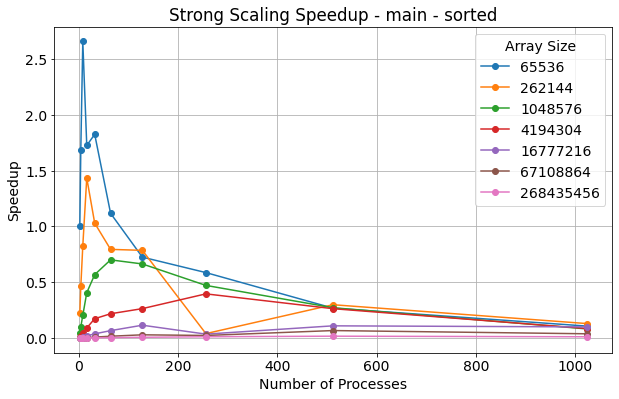

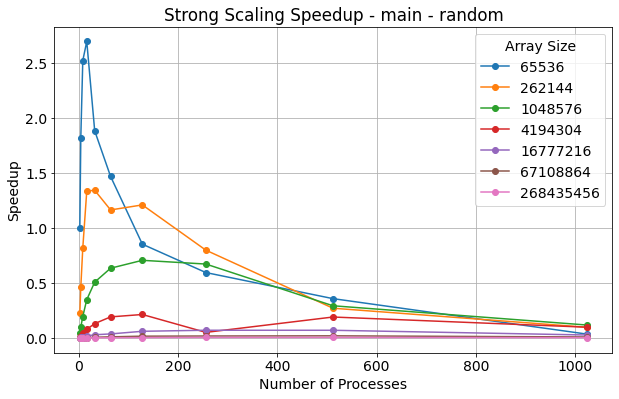

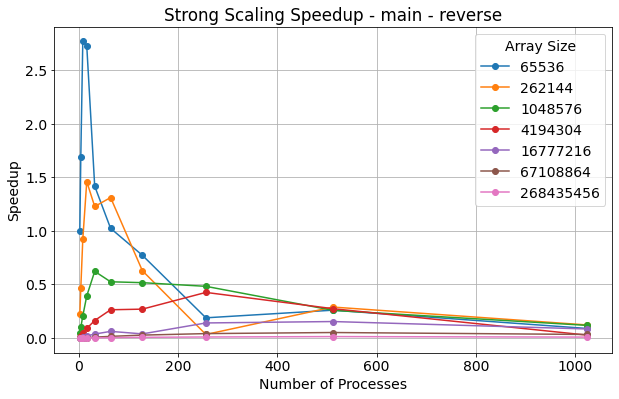

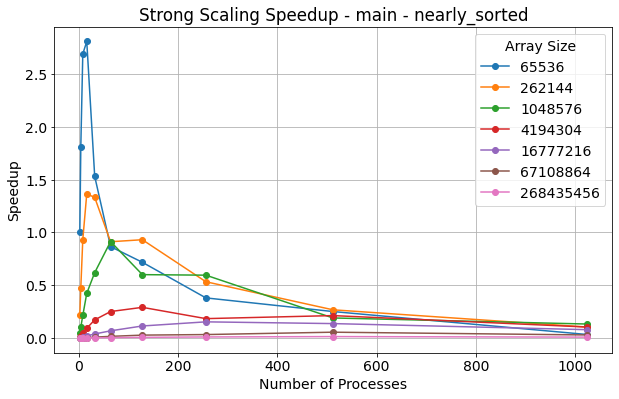

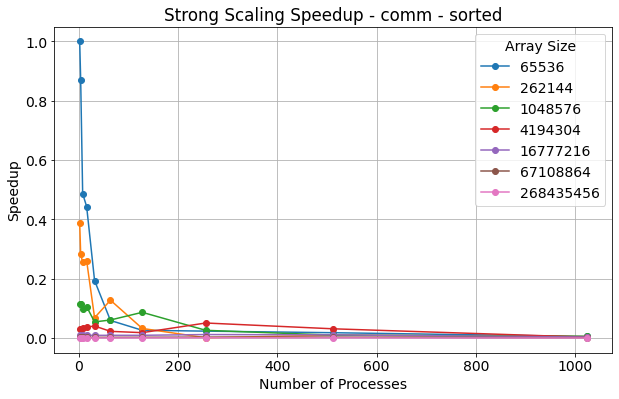

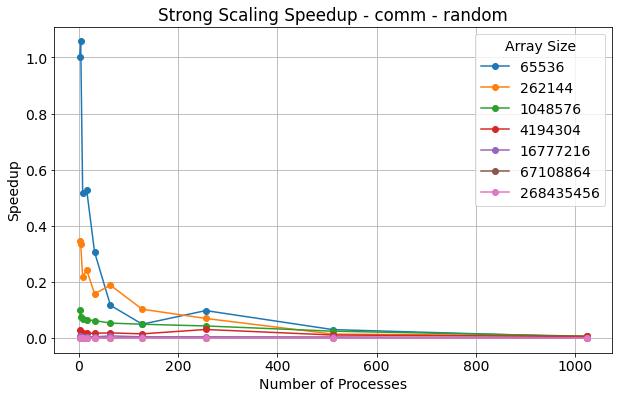

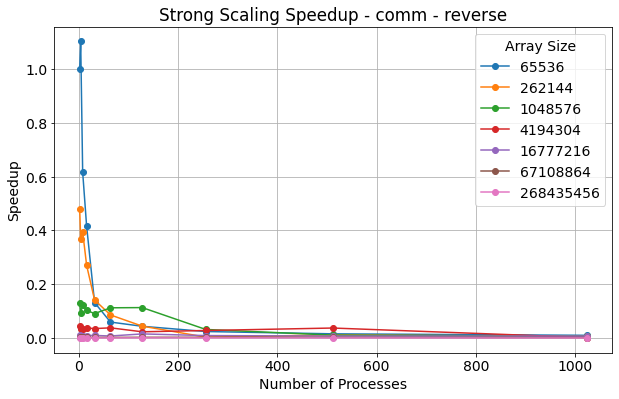

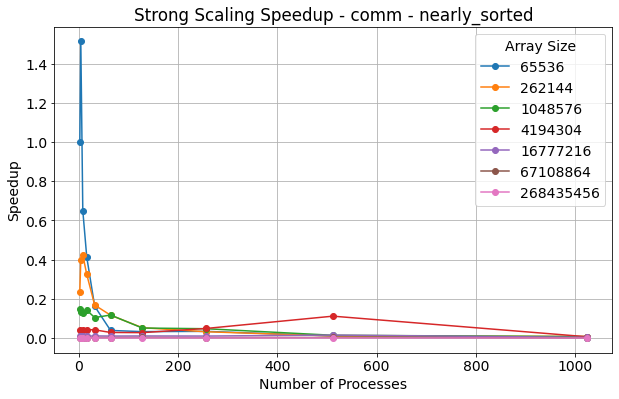

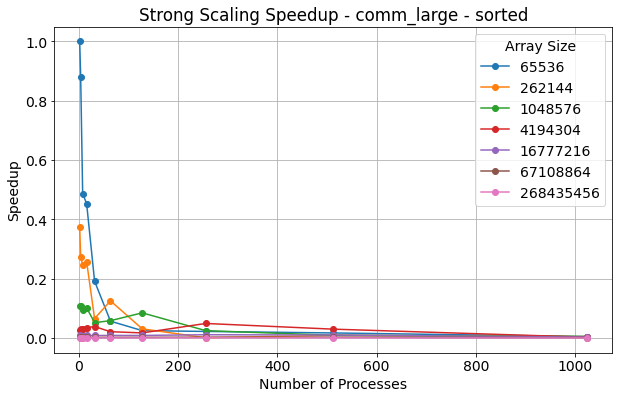

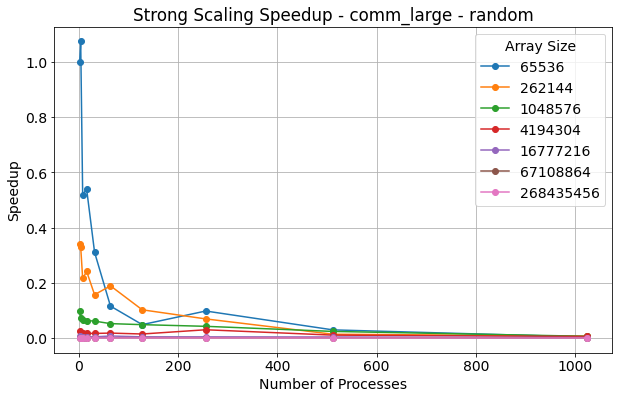

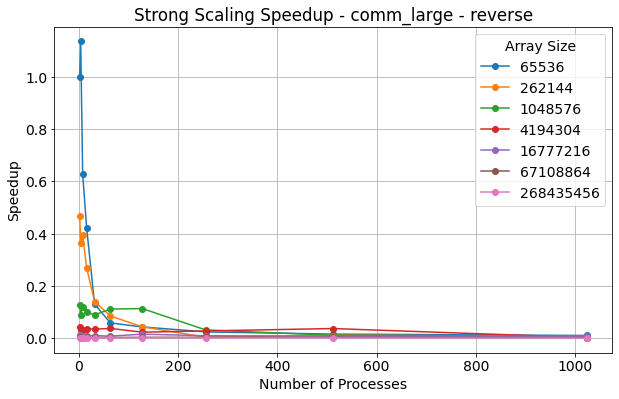

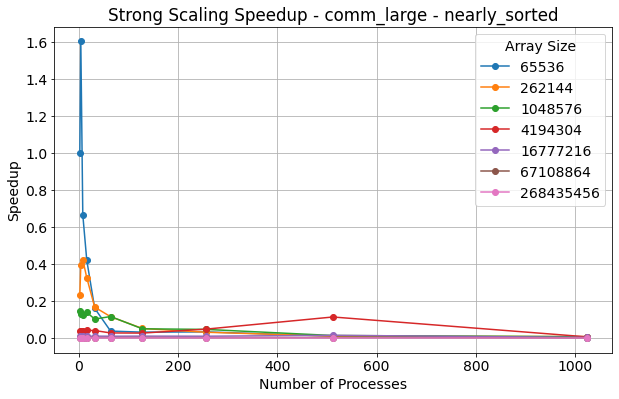

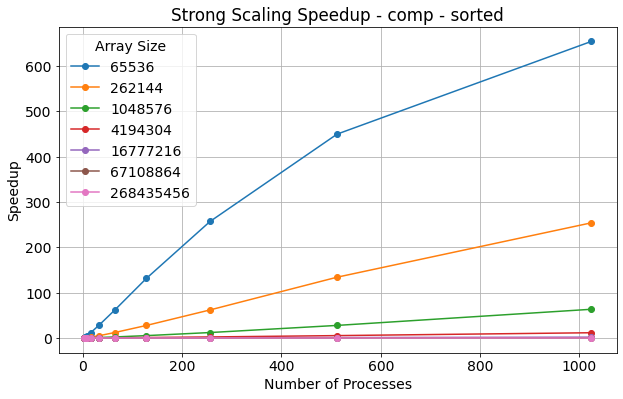

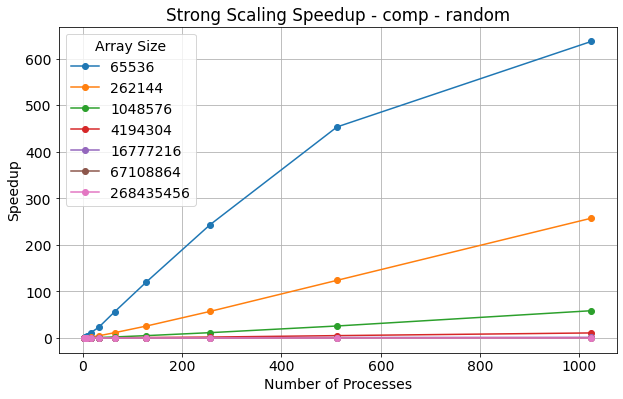

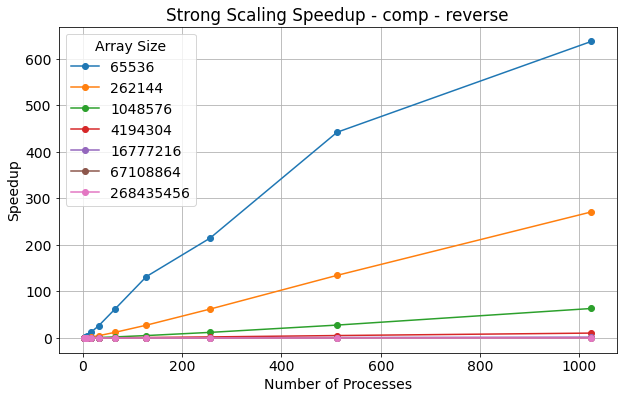

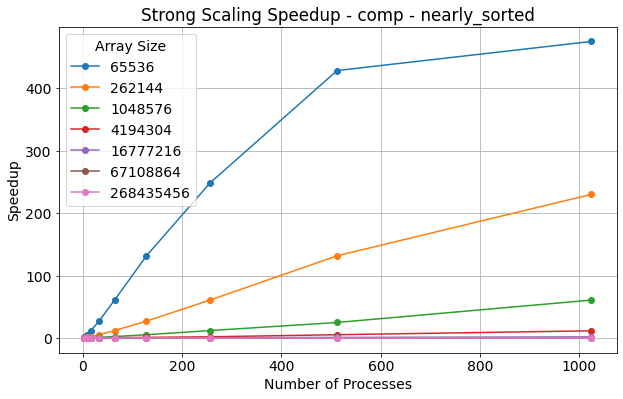

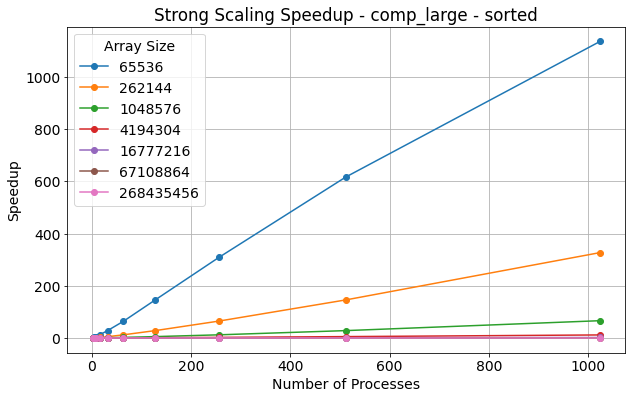

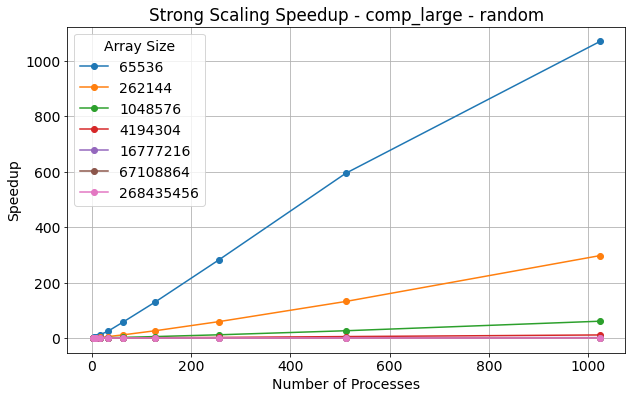

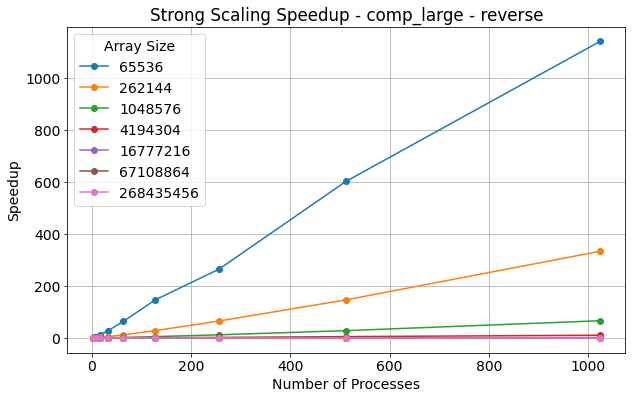

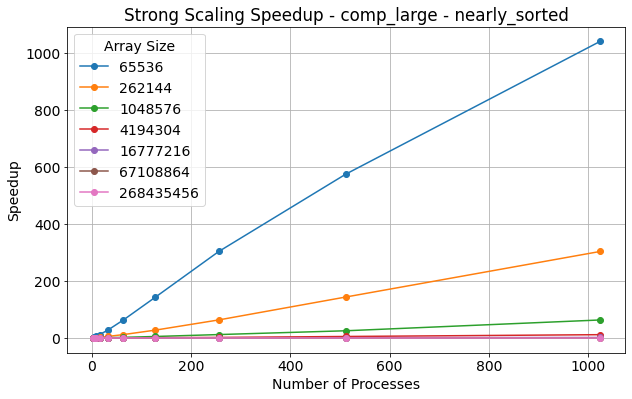

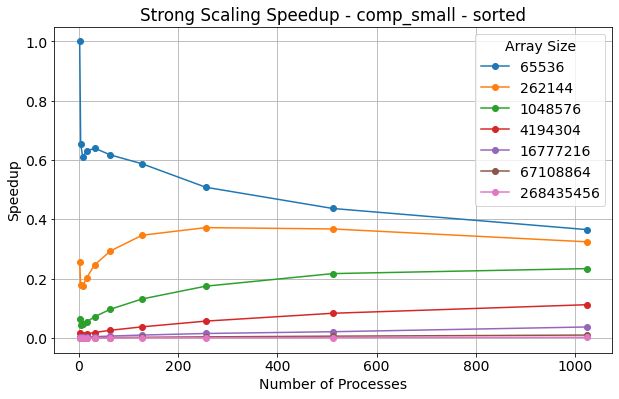

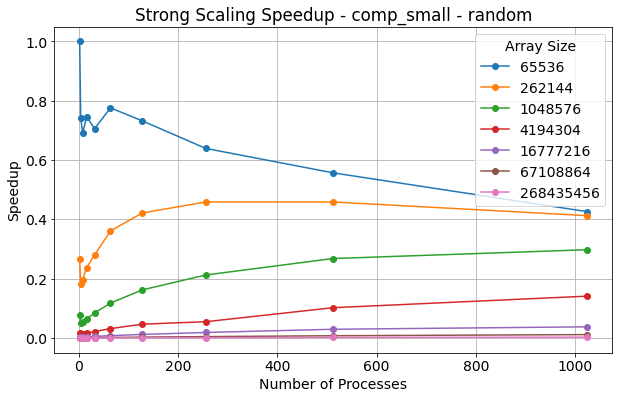

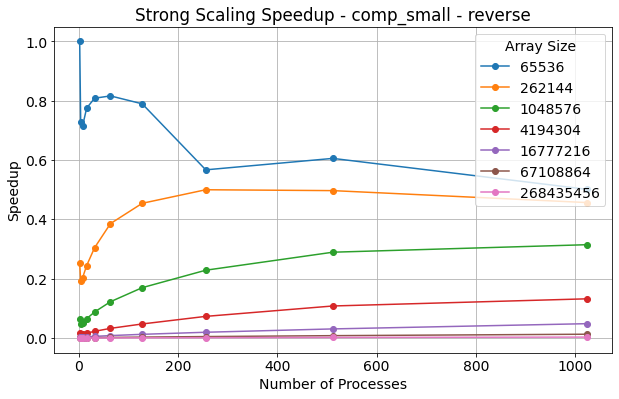

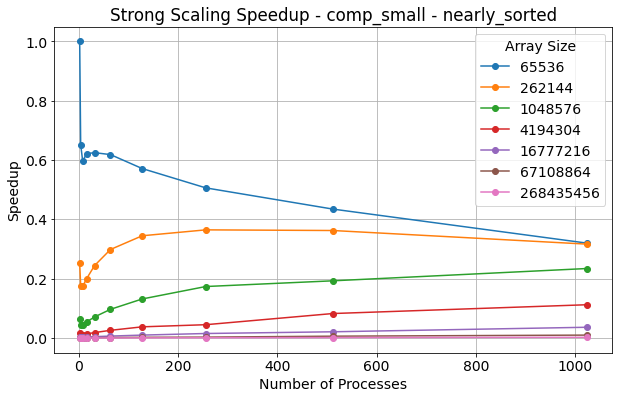

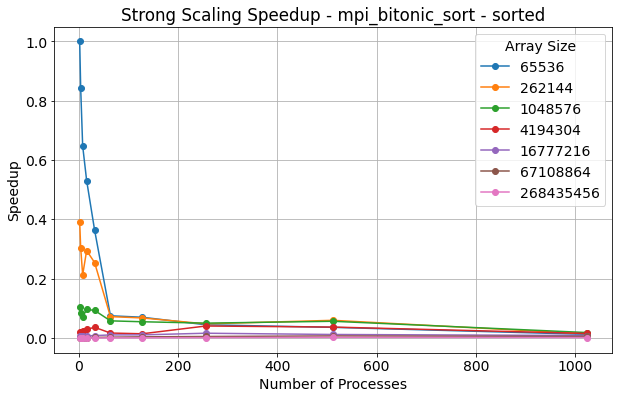

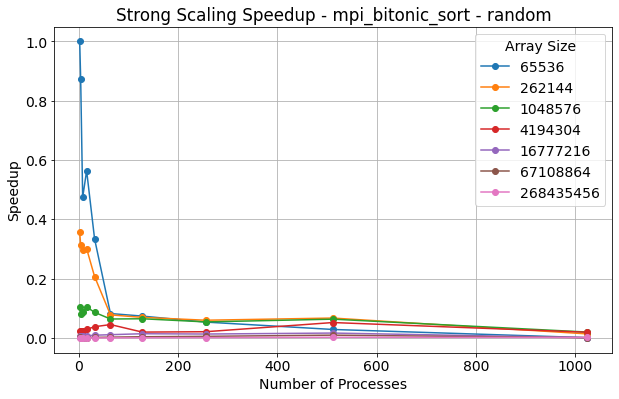

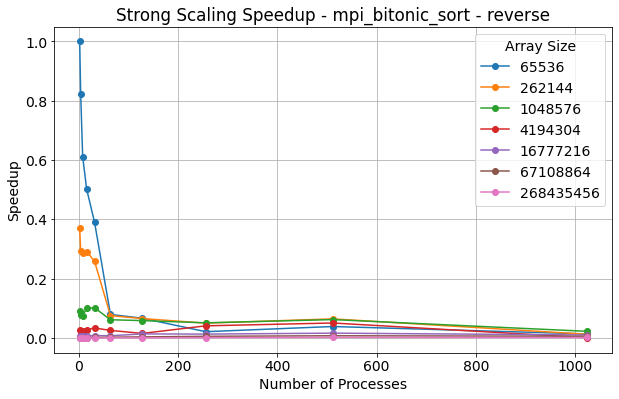

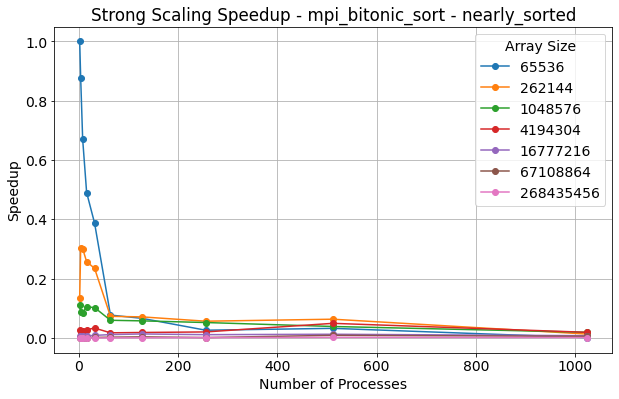

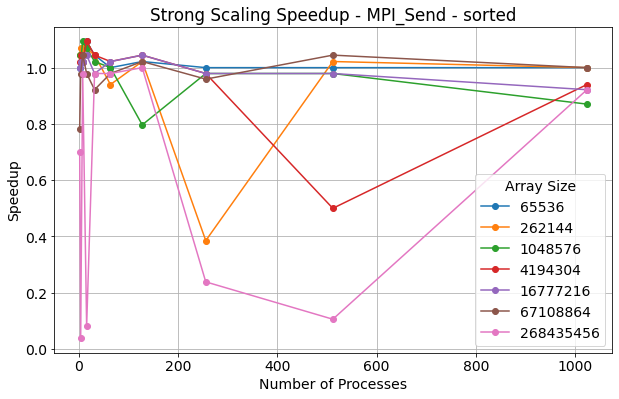

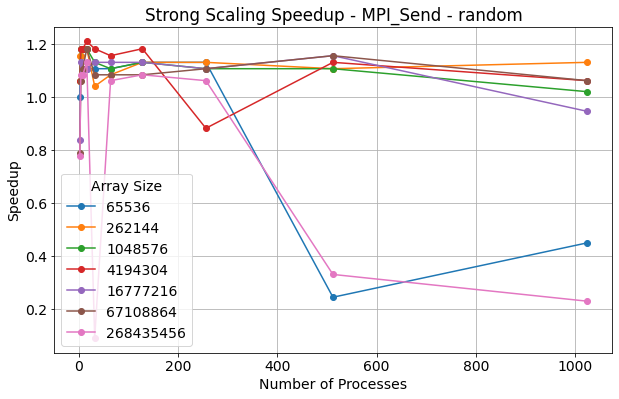

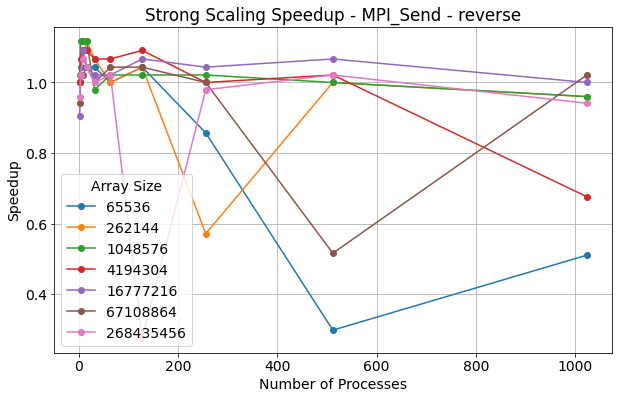

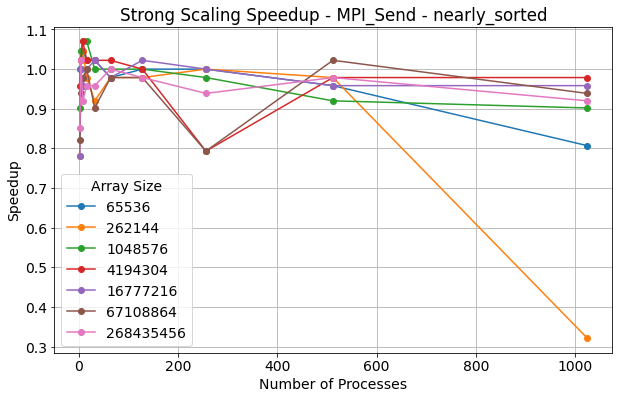

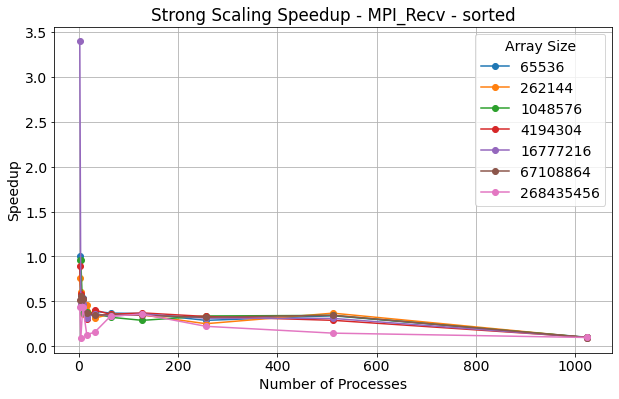

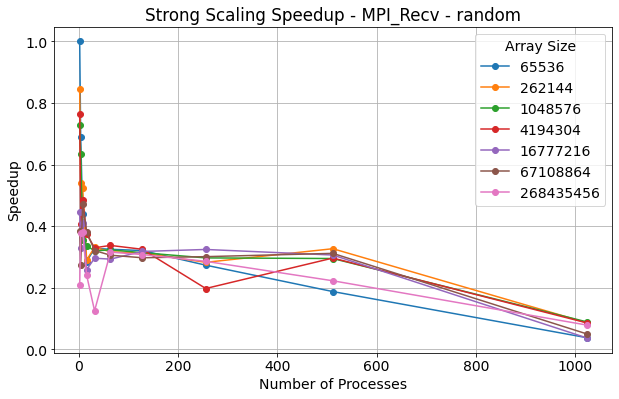

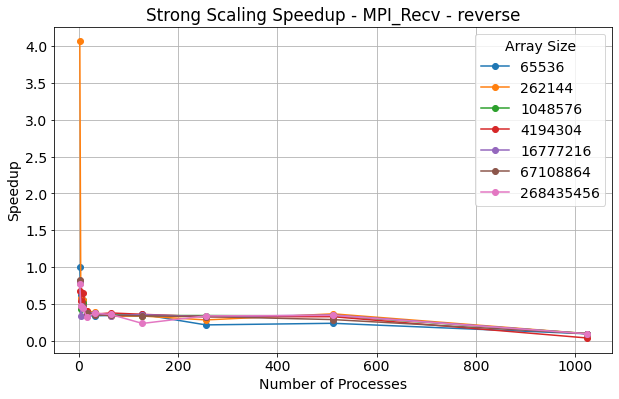

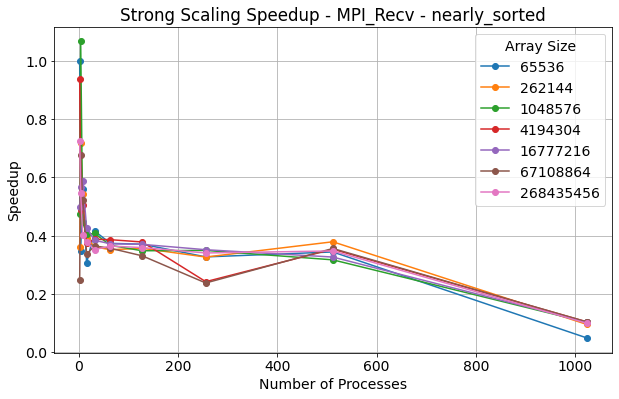

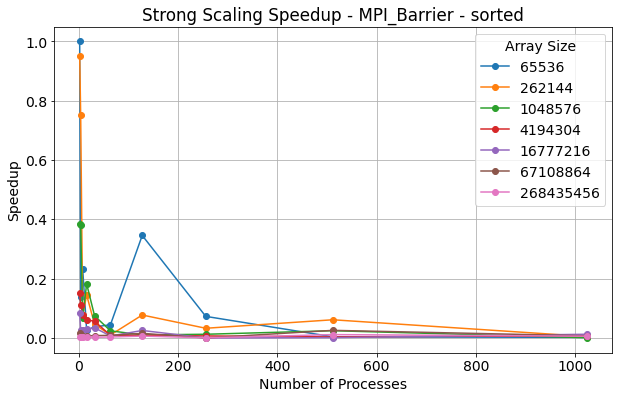

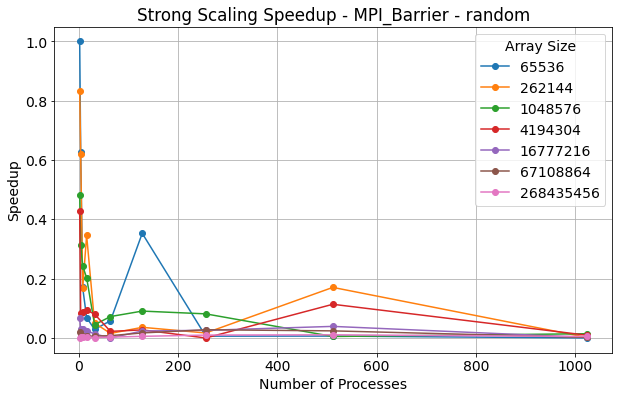

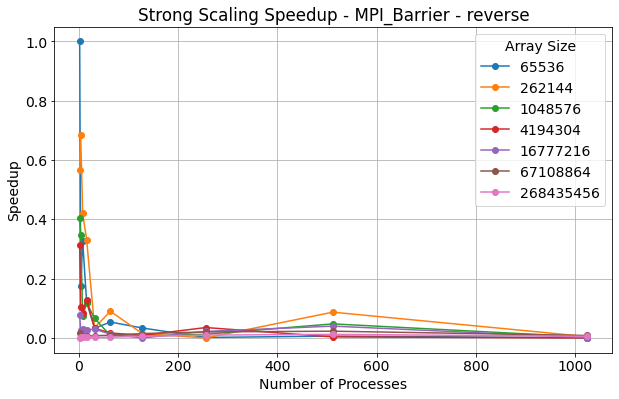

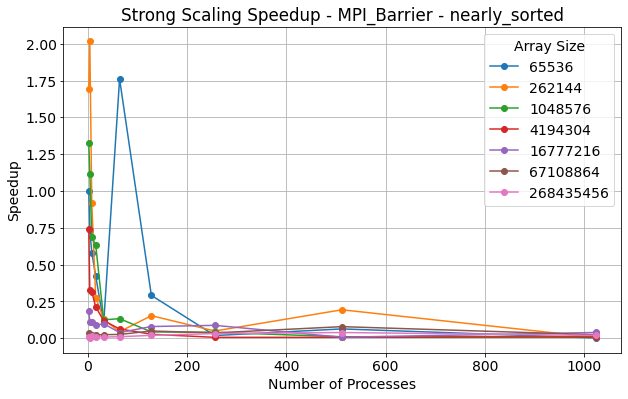

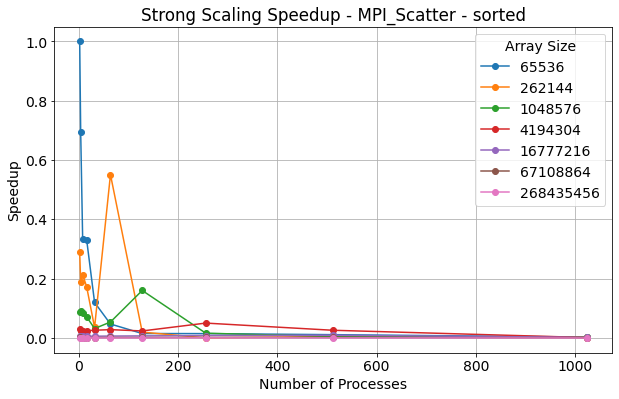

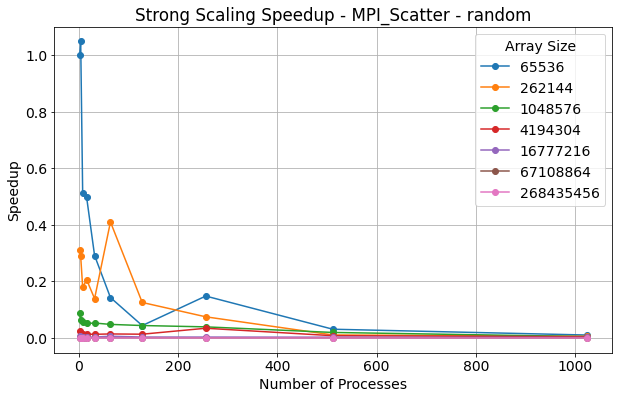

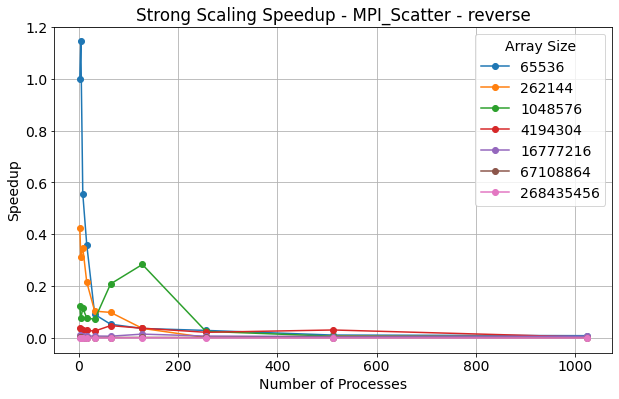

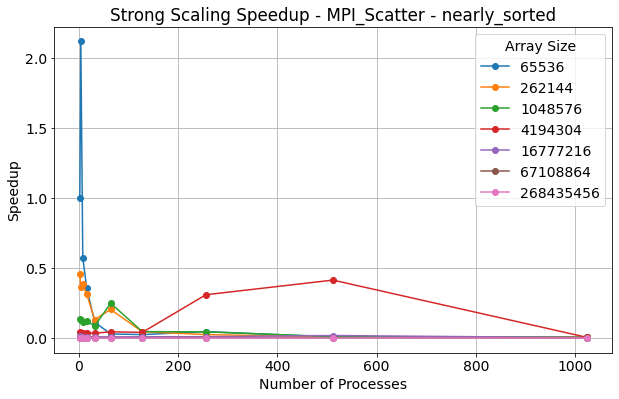

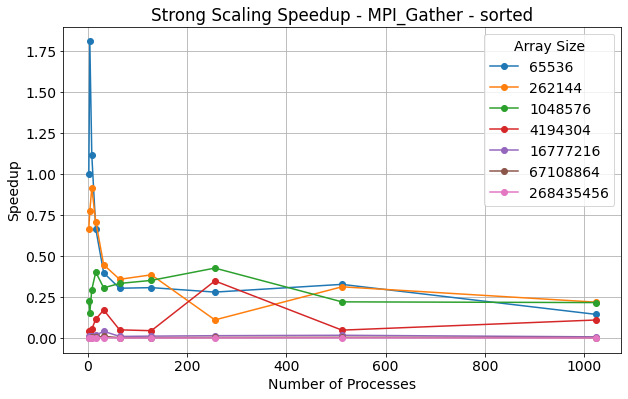

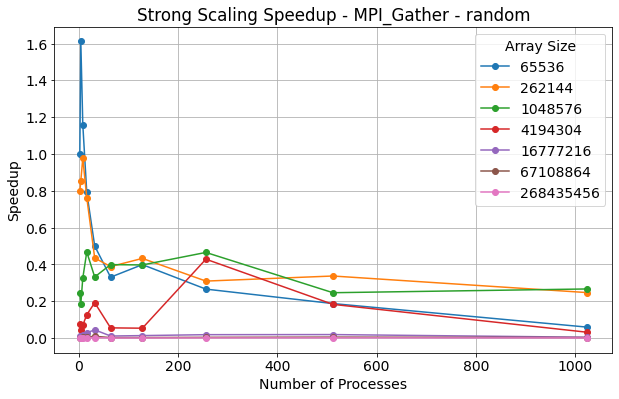

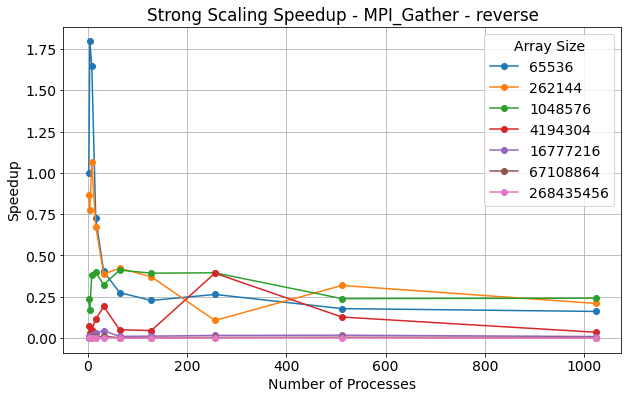

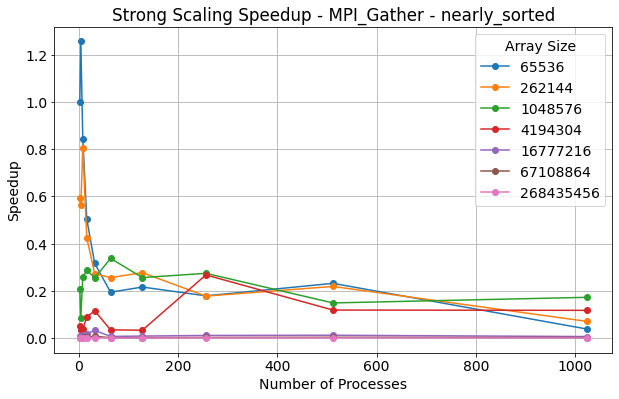

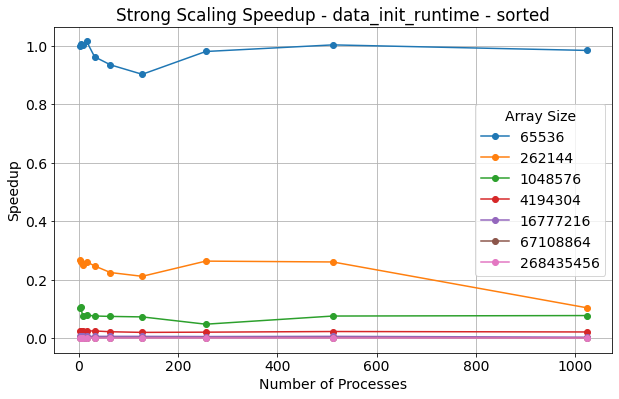

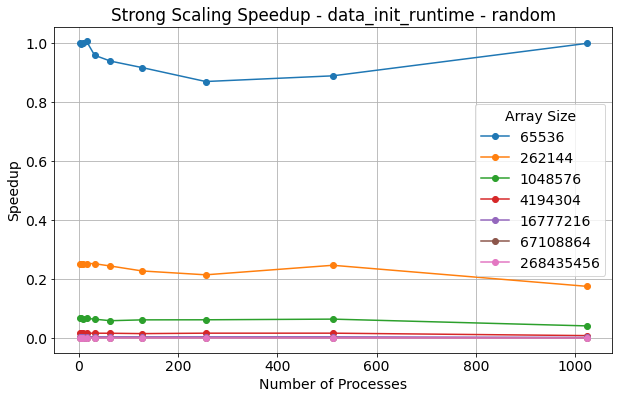

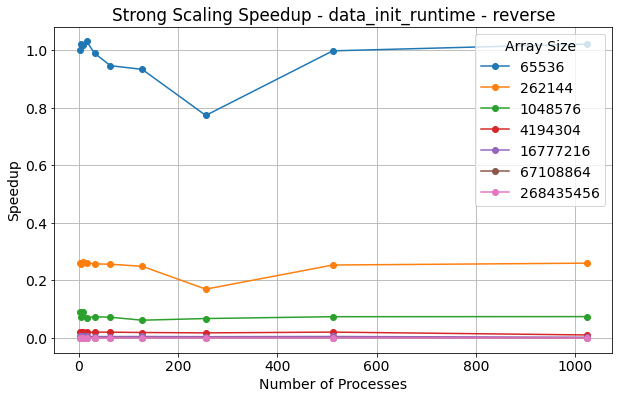

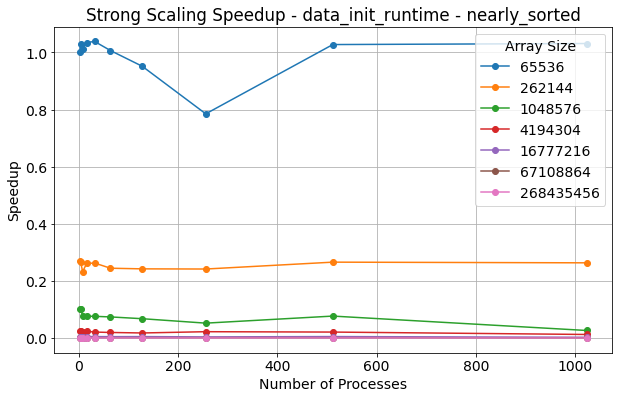

In [54]:
# Cell 10: Generate strong scaling speedup plots for each input_type
for node in nodes_of_interest:
    for input_type in input_types:
        data = metrics_df[(metrics_df['node'] == node) & (metrics_df['input_type'] == input_type)]
        if data.empty:
            continue
        # Compute speedup relative to the minimum number of processes
        data = data.sort_values('num_procs')
        base_time = data.iloc[0]['Avg time/rank']
        data['Speedup'] = base_time / data['Avg time/rank']
        pivot_table = data.pivot(index='num_procs', columns='array_size', values='Speedup')
        pivot_table.plot(title=f"Strong Scaling Speedup - {node} - {input_type}", marker='o', figsize=(10, 6))
        plt.xlabel('Number of Processes')
        plt.ylabel('Speedup')
        plt.grid(True)
        plt.legend(title='Array Size')
        plt.show()


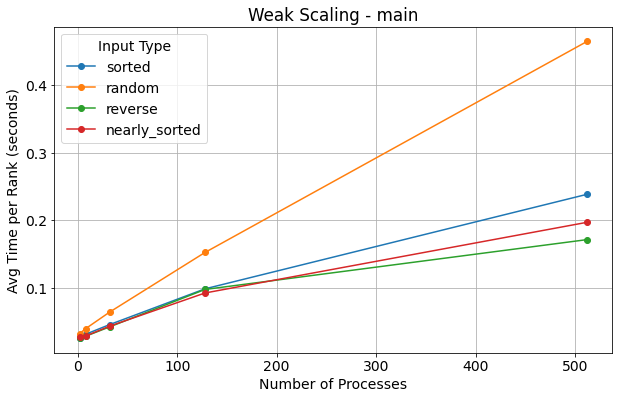

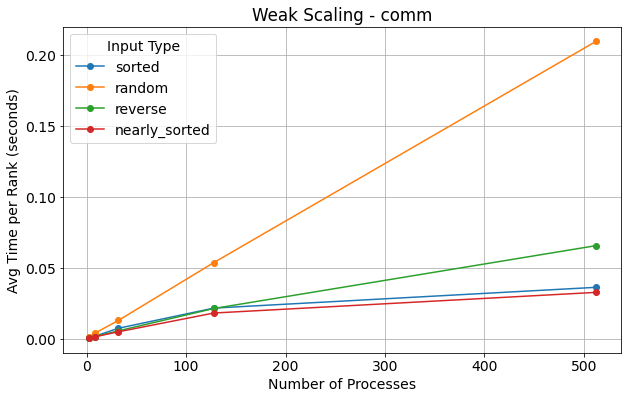

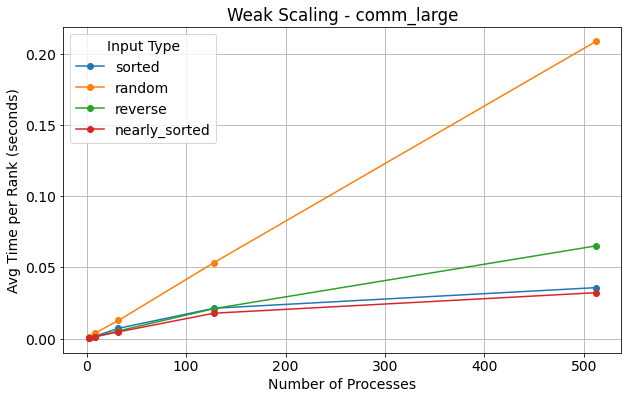

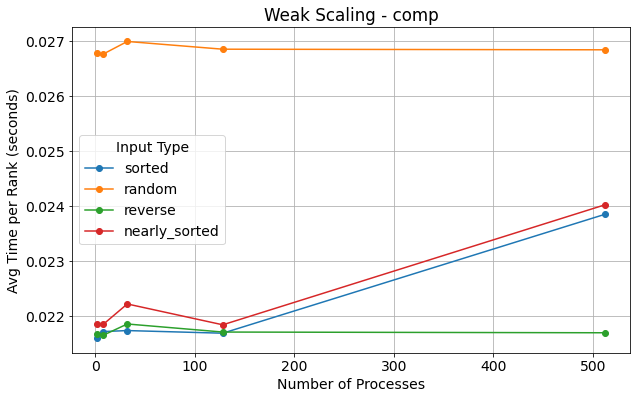

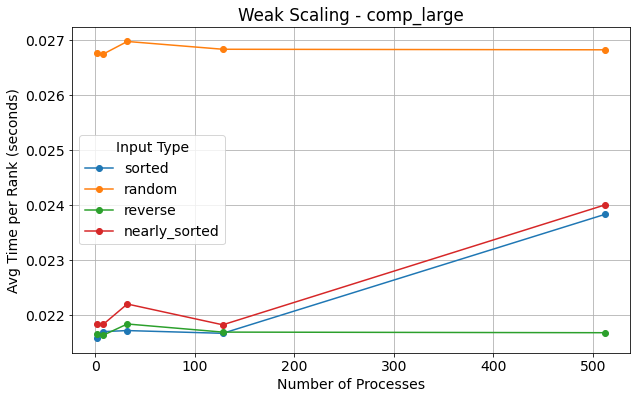

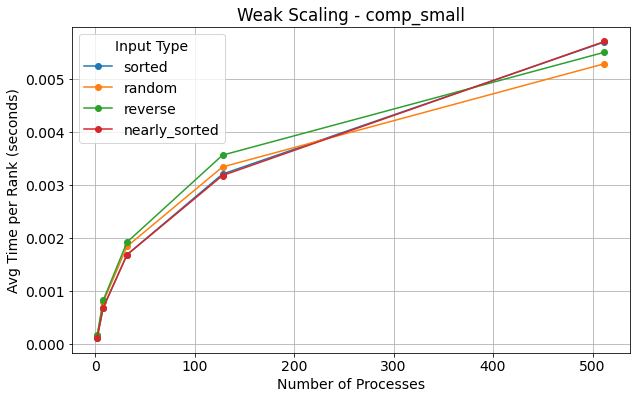

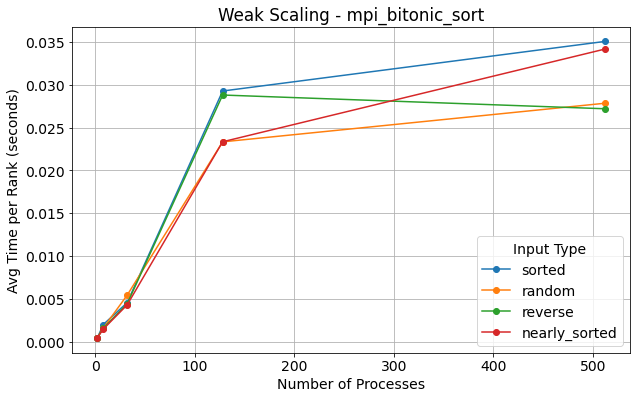

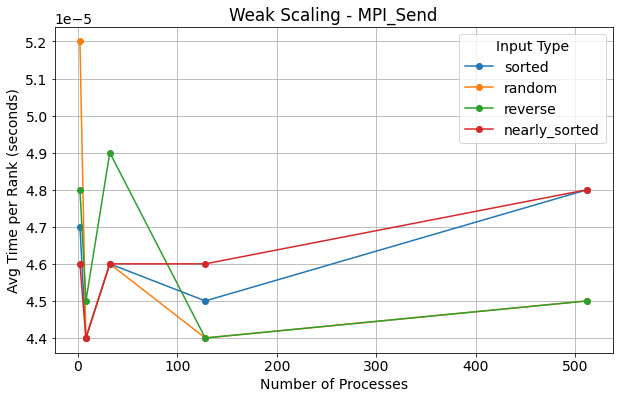

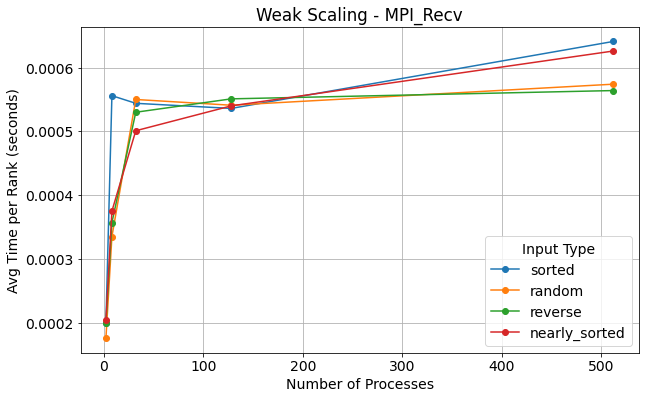

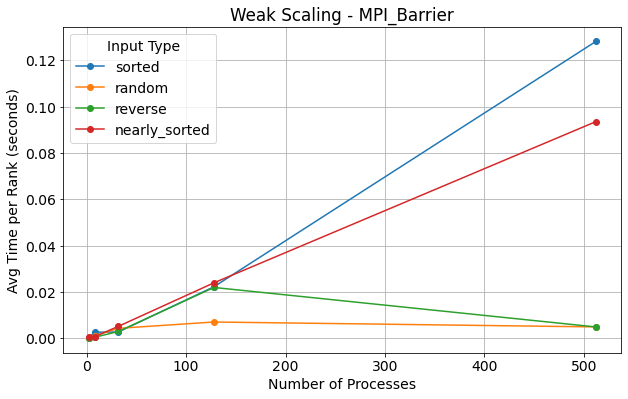

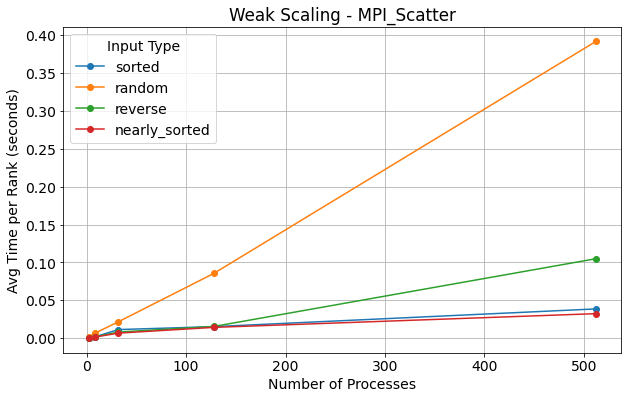

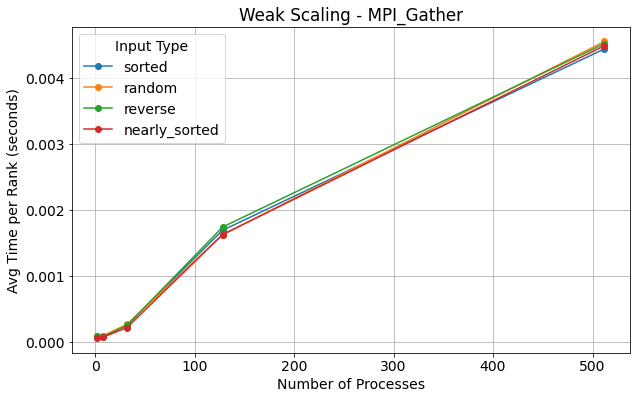

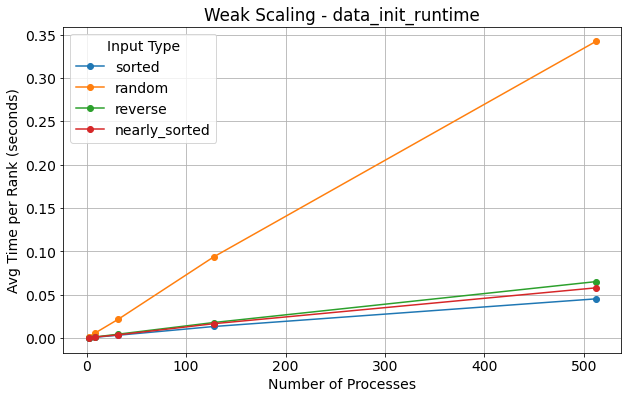

In [55]:
# Cell 11: Generate combined weak scaling plots for each node

import matplotlib.pyplot as plt

# Ensure 'num_procs' and 'array_size' are integers
metrics_df['num_procs'] = metrics_df['num_procs'].astype(int)
metrics_df['array_size'] = metrics_df['array_size'].astype(int)

# Compute the base workload per process
base_num_procs = metrics_df['num_procs'].min()
base_array_size = metrics_df[metrics_df['num_procs'] == base_num_procs]['array_size'].min()
array_size_per_proc = base_array_size // base_num_procs

# Compute expected array_size for each num_procs
metrics_df['expected_array_size'] = metrics_df['num_procs'] * array_size_per_proc

# Filter for weak scaling
weak_scaling_df = metrics_df[metrics_df['array_size'] == metrics_df['expected_array_size']]

# Prepare to plot
for node in nodes_of_interest:
    data = weak_scaling_df[weak_scaling_df['node'] == node]
    if data.empty:
        continue

    plt.figure(figsize=(10, 6))
    for input_type in input_types:
        data_input = data[data['input_type'] == input_type]
        if data_input.empty:
            continue
        data_input = data_input.sort_values('num_procs')
        plt.plot(data_input['num_procs'], data_input['Avg time/rank'], marker='o', label=input_type)
    
    plt.title(f"Weak Scaling - {node}")
    plt.xlabel('Number of Processes')
    plt.ylabel('Avg Time per Rank (seconds)')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()
